In [ ]:
!wget "https://www.dropbox.com/scl/fo/hlujog78gi4zy8duy683h/AF-i2zym-HVnaEKJe4MhEv4?rlkey=tzdr361wsqcr1oda3vrfmypcf&dl=1" -O dropbox_folder.zip
!unzip dropbox_folder.zip -d extracted_data/

--2025-07-02 05:59:28--  https://www.dropbox.com/scl/fo/hlujog78gi4zy8duy683h/AF-i2zym-HVnaEKJe4MhEv4?rlkey=tzdr361wsqcr1oda3vrfmypcf&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4e56b5a375707c88061ab8c4c6.dl.dropboxusercontent.com/zip_download_get/CQHm9SPj7nTDV8Ehe_APZ2wevF2c73RJYbApn_umtT33NxFGgHtGhbf2jM6lnWfwMUXcR1sKXoWd5wlZIT-DuAyP3WUPO7UbnSgQBOYrotD8Pw# [following]
--2025-07-02 05:59:29--  https://uc4e56b5a375707c88061ab8c4c6.dl.dropboxusercontent.com/zip_download_get/CQHm9SPj7nTDV8Ehe_APZ2wevF2c73RJYbApn_umtT33NxFGgHtGhbf2jM6lnWfwMUXcR1sKXoWd5wlZIT-DuAyP3WUPO7UbnSgQBOYrotD8Pw
Resolving uc4e56b5a375707c88061ab8c4c6.dl.dropboxusercontent.com (uc4e56b5a375707c88061ab8c4c6.dl.dropboxusercontent.com)... 162.125.80.15, 2620:100:6035:15::a27d:550f
Connecting to uc4e56b5a375707c88061ab8c4c6

# Merging and Initializing(Do not run) For PSID


In [ ]:
import pandas as pd
import re
from pathlib import Path
#read the do file and change it to csv
def extract_specs_from_do(do_path):
    with open(do_path, "r") as f:
        content = f.read()
    matches = re.findall(r"\s*(\w+)\s+(\d+)\s*-\s*(\d+)", content)

    var_count = {}
    names = []
    for var, _, _ in matches:
        if var not in var_count:
            var_count[var] = 1
            names.append(var)
        else:
            var_count[var] += 1
            names.append(f"{var}_{var_count[var]}")

    colspecs = [(int(start) - 1, int(end)) for _, start, end in matches]
    return colspecs, names

def convert_psid_to_csv(do_file, txt_file, year, output_file):
    colspecs, names = extract_specs_from_do(do_file)
    df = pd.read_fwf(txt_file, colspecs=colspecs, names=names)
    df["year"] = year
    df.to_csv(output_file, index=False)
    print(f"✅ Saved {output_file} with {len(df)} rows and {len(df.columns)} columns")

#
for year in range(1968, 2025):
  do_path = Path(f"FAM{year}.do")
  txt_path = Path(f"FAM1970{year}.txt")
  output_csv = Path(f"psid_{year}.csv")

  # Run conversion
  convert_psid_to_csv(do_path, txt_path, year, output_csv)


In [ ]:
# reads from the folders as excel and converts them to excel while renaming collumns and adding a year column

from pathlib import Path
import pandas as pd
def build_psid_panel(
        in_folder,          # folder with 1968.xlsx, 1969.xlsx, …
        out_folder,         # where cleaned files are saved
        years,              # iterable, e.g. range(1968, 2024)
        seq_map=None,       # {year: "ER34xxx"} if you want that col renamed → seq_num
):
    in_folder, out_folder = Path(in_folder), Path(out_folder)
    out_folder.mkdir(parents=True, exist_ok=True)

    frames = []

    for yr in years:
        f_in  = in_folder  / f"{yr}.xlsx"
        f_out = out_folder / f"{yr}_clean.csv"

        if not f_in.exists():
            print(f"⚠️  {f_in.name} missing – skipped")
            continue

        # 1️⃣ read the FIRST worksheet (sheet_name=0)
        df = pd.read_excel(f_in, sheet_name=0, engine="openpyxl")

        # 2️⃣ rename permanent IDs if present
        ren = {}
        if "ER30001" in df.columns: ren["ER30001"] = "perm_fam_id"
        if "ER30002" in df.columns: ren["ER30002"] = "perm_per_id"

        if ren: df.rename(columns=ren, inplace=True)

        # 4️⃣ add year column
        df["year"] = yr

        # 5️⃣ save cleaned copy
        df.to_csv(f_out, index=False)


        frames.append(df)
        print(f"✅ {f_out.name} written ({len(df):,} rows, {df.shape[1]} cols)")

    if not frames:
        raise RuntimeError("No files processed – check folder/years list.")

    indiv_long = pd.concat(frames, ignore_index=True)
    print(f"\n✨ Combined panel: {len(indiv_long):,} rows • {indiv_long.shape[1]} cols")
    return indiv_long

data_folder = "/content/extracted_data/RawData/IndivData"
out_folder = ""
years = range(1968, 2025)
indiv_long = build_psid_panel(data_folder, out_folder, years)

In [ ]:
#Change Data format to parquet
for year in range(1968,2025):
  try:
    df = pd.read_csv(f"{year}_clean.csv")               # ⚠️ full file in RAM
    df.to_parquet(f"{year}.parquet",
              compression="zstd",          # snappy | zstd | brotli
              index=False)
  except Exception as e:
    print(year)
    continue


In [ ]:
#concat and merge all indivFIles
frames=[]
in_folder = Path("/content/extracted_data/IndivData")
for year in range(1968,2025):
  f_in  = in_folder  / f"{year}.parquet"
  if not f_in.exists():
            print(f"⚠️  {f_in.name} missing – skipped")
            continue

  #check if it exists
  frames.append(pd.read_parquet(f"/content/extracted_data/IndivData{year}.parquet"))

pd.concat(frames, ignore_index=True).to_parquet("IndALL.parquet")

In [ ]:
import pandas as pd
#read all the data
dfall = pd.read_parquet("/content/extracted_data/IndivData/IndALL.parquet")
#read 2015 and 2016 merged data
d2015_2016 = pd.read_csv('/content/extracted_data/MergedData/2015_2016INdv.csv')

In [ ]:
#only families that participated in the 2016
d2015_2016.rename(columns={"ER30001": "Perm_FID",
                             "ER30002"  : "Perm_IID",'WB16IWYR' :'year'},inplace=True)
dfall_filtered = dfall[dfall['Perm_FID'].isin(d2015_2016['Perm_FID'])]
del dfall
#drop the 2015
dfall_filtered=dfall_filtered[dfall_filtered['year']!=2015]


In [ ]:
#merge with the 2015 + 2016
pd.concat([d2015_2016,dfall_filtered],ignore_index=True,).to_parquet("IndALL_2015_2016.parquet")

# Data And Visualization For the 2016 and INDIV


In [ ]:
#read the merged file
import pandas as pd
merged = pd.read_parquet("/content/extracted_data/MergedData/IndALL_2015_2016.parquet")
merged2015=pd.read_parquet("/content/extracted_data/IndivData/2015.parquet")
merged = pd.concat([merged,merged2015],ignore_index=True)

In [ ]:
#Number of Generational unique families
print("Number Of Generational Families",merged['Perm_FID'].nunique())

#number of indiviauls that  participated in the survey Oly
print('Number Of Indiviuals ',len(merged[merged['year']==2016]))

#all families that particpated (include families made after a child grows into an adult)
print('All Families ',(merged[merged['year']==2016])['family_id'].nunique())

#Number Of Indivuals that answered the first question related to the numerical literacy
print('number of indivuals that answered the first question  '  , len(merged[(merged['WB16K1']==1) | (merged['WB16K1']==5)]))



Number Of Generational Families 2107
Number Of Indiviuals  8341
All Families  5763
number of indivuals that answered the first question   8226


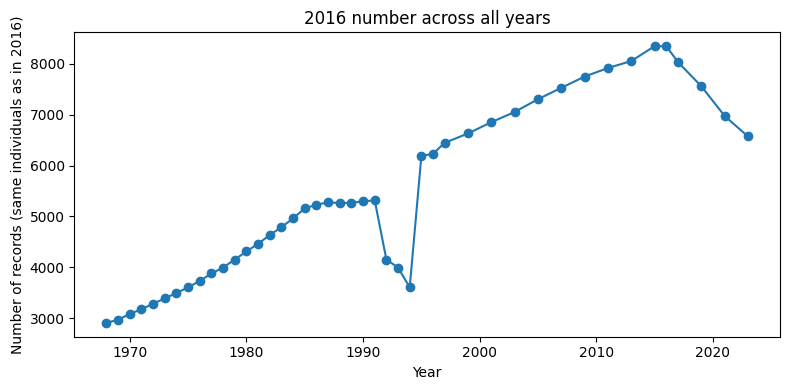

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0) Point to your DataFrame and the relevant column names
# ------------------------------------------------------------------
df          = merged            # <-- change if your DataFrame is named differently
col_year    = "year"            # e.g. "wave", "survey_year"
col_family  = "Perm_FID"        # family identifier
col_person  = "Perm_IID"          # person identifier (individual)
# 1) Build the set of (family, person) pairs observed in 2016 only
# ------------------------------------------------------------------
keys_2016 = (
    df.loc[df[col_year] == 2016, [col_family, col_person]]
      .drop_duplicates()
)
# 2) Keep rows whose key exists in that 2016 subset
#    (inner-joining is vectorised and memory-efficient)
# ------------------------------------------------------------------
df_subset = (
    df.merge(keys_2016, on=[col_family, col_person], how="inner")
)

# 3) Row-count per year for that restricted population
# ------------------------------------------------------------------
year_counts = (
    df_subset.groupby(col_year)
             .size()
             .reset_index(name="n_records")
             .sort_values(col_year)
)


# 4) Quick line plot (optional)
# ------------------------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(year_counts[col_year], year_counts["n_records"], marker="o")
plt.xlabel("Year")
plt.ylabel("Number of records (same individuals as in 2016)")
plt.title("2016 number across all years")
plt.tight_layout()
plt.show()

**The figure shows a consistent increase in the number of individuals (tracked since 2016) across years, with a dip around the early 1990s likely due to sample changes. The trend confirms strong longitudinal continuity in the dataset.:**

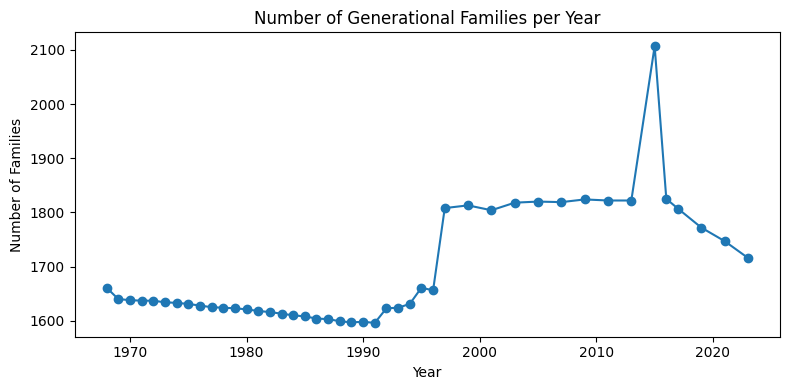

In [ ]:
#plots

import pandas as pd
import matplotlib.pyplot as plt

# 1) Replace “merged” with your DataFrame name
df = merged

# 2) Edit these if your column names differ
col_year   = "year"       # e.g. "year", "survey_year", "YR"
col_family = "Perm_FID"   # unique family identifier

# 3) Count unique families per year
counts = (
    df.groupby(col_year)[col_family]
      .nunique()
      .reset_index(name="n_families")
      .sort_values(col_year)
)

# 4) Plot
plt.figure(figsize=(8,4))
plt.plot(counts[col_year], counts["n_families"], marker="o")
plt.xlabel("Year")
plt.ylabel("Number of Families")
plt.title("Number of Generational Families per Year")
plt.tight_layout()
plt.show()



**The number of generational families remains fairly stable over time, with a notable increase in the mid-1990s and a spike around 2015. This likely reflects improvements in linking family units across generations in newer waves.**

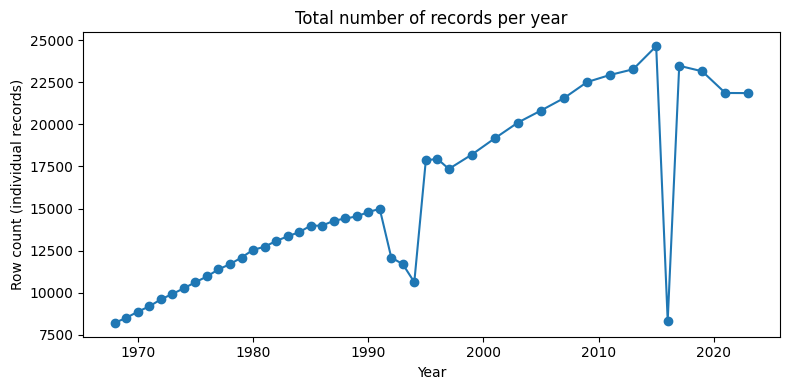

In [ ]:
# df = your DataFrame (e.g. merged)
col_year = "year"        # adjust if named differently

row_counts = (
    df.groupby(col_year)
      .size()                 # counts rows
      .reset_index(name="n_records")
      .sort_values(col_year)
)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(row_counts[col_year], row_counts["n_records"], marker="o")
plt.xlabel("Year")
plt.ylabel("Row count (individual records)")
plt.title("Total number of records per year")
plt.tight_layout()
plt.show()

**The total number of individual records increases steadily over time, with sharp drops around the early 1990s and 2017, likely due to data collection issues or processing anomalies. Overall, the trend reflects growing sample coverage in PSID.**

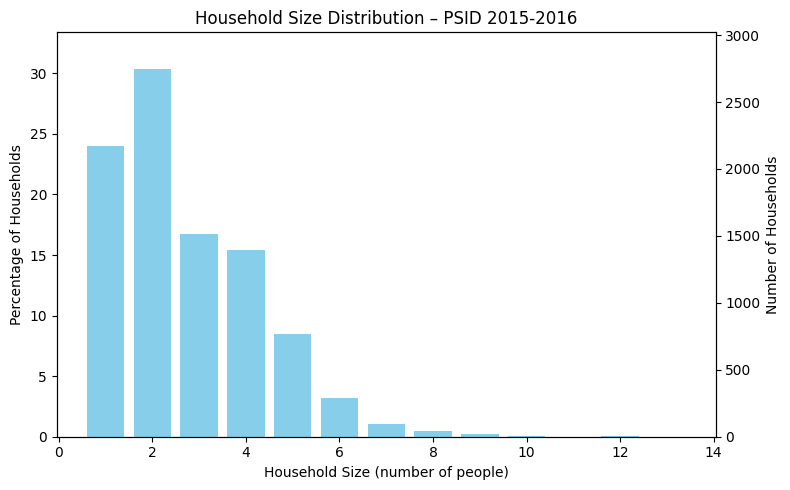

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# ---- 1. Filter 2015 data ----
df2017 = merged[merged["year"] == 2015]

# ---- 2. Count people per household ----
household_sizes = df2017.groupby("ER34301").size()

# ---- 3. Distribution: counts ➜ percentages ----
size_counts = household_sizes.value_counts().sort_index()
size_percent = (size_counts / size_counts.sum()) * 100

# ---- 4. Plot with dual y-axes ----
fig, ax1 = plt.subplots(figsize=(8, 5))

bars = ax1.bar(size_percent.index, size_percent.values, color="skyblue")
ax1.set_xlabel("Household Size (number of people)")
ax1.set_ylabel("Percentage of Households")
ax1.set_ylim(0, size_percent.max() * 1.1)
ax1.set_title("Household Size Distribution – PSID 2015-2016")

# Right Y-axis: Raw counts
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Households")
ax2.set_ylim(0, size_counts.max() * 1.1)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



**The distribution shows that most households in the 2015–2016 PSID consist of 1 to 4 members, with two-person households being the most common. Larger household sizes are increasingly rare.**

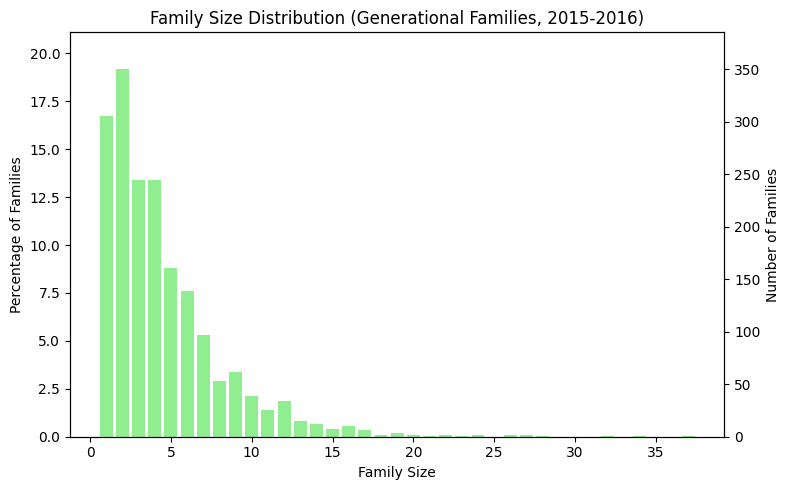

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter 2016 data
df2015 = merged[merged["year"] == 2016]

# Step 1: Count individuals per family
family_sizes = df2015.groupby("Perm_FID").size()

# Step 2: Count how many families are of each size
family_size_counts = family_sizes.value_counts().sort_index()
family_size_percent = (family_size_counts / family_size_counts.sum()) * 100

# Step 3: Plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(8, 5))

bars = ax1.bar(family_size_counts.index, family_size_percent.values, color="lightgreen")
ax1.set_xlabel("Family Size")
ax1.set_ylabel("Percentage of Families")
ax1.set_ylim(0, family_size_percent.max() * 1.1)
ax1.set_title("Family Size Distribution (Generational Families, 2015-2016)")

# Right Y-axis for number of families
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Families")
ax2.set_ylim(0, family_size_counts.max() * 1.1)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()




**The majority of generational families in the 2015–2016 PSID have fewer than 6 members, with a steep decline in frequency as family size increases, indicating that very large extended families are rare.**

In [ ]:
df['REL']

,REL
642520,10
642521,40
642522,10
642523,10
642524,20
...,...
667152,30
667153,30
667154,10
667155,20


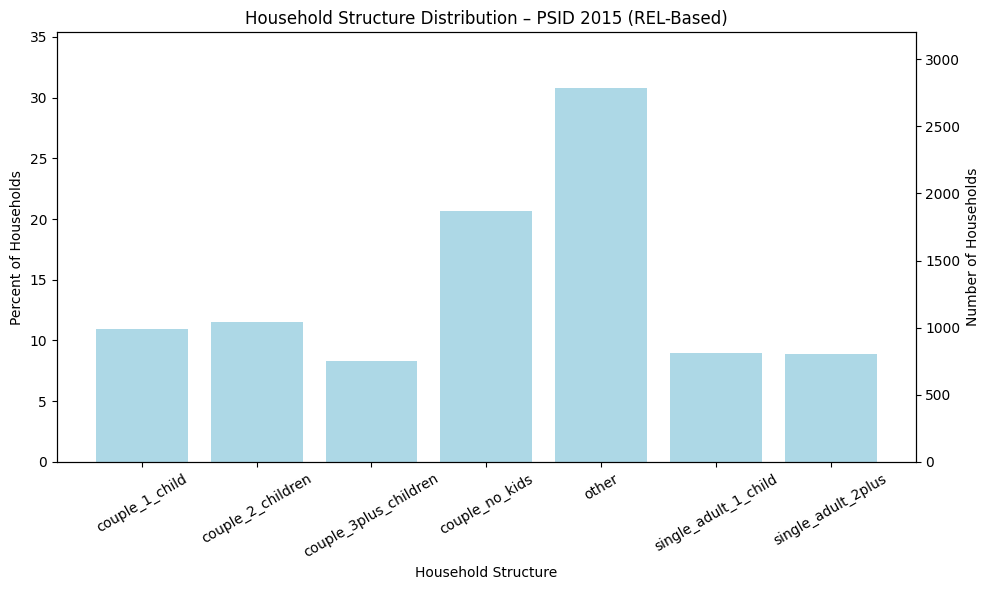

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1. LOAD & PREPARE ----------
df = merged[merged["year"] == 2015].copy()
df.rename(columns={"ER34301": "HH_ID", "ER34303": "REL"}, inplace=True)

# Convert REL to numeric but don't fill NAs yet
df["REL"] = pd.to_numeric(df["REL"], errors="coerce")

# Filter out households where ALL REL values are missing (NaN)
valid_households = df.groupby("HH_ID")["REL"].apply(lambda x: x.notna().any())
df = df[df["HH_ID"].isin(valid_households[valid_households].index)]

# Now safely convert REL to int, filling NaNs with 0
df["REL"] = df["REL"].fillna(0).astype(int)

# ---------- 2. GROUP ATTRIBUTES ----------
grouped = df.groupby("HH_ID")
size = grouped.size()
has_spouse = grouped["REL"].apply(lambda x: any(r in [20, 22] for r in x))
num_children = grouped["REL"].apply(lambda x: sum(r in (30, 33, 35) for r in x))

hh = pd.DataFrame({
    "size": size,
    "spouse": has_spouse,
    "children": num_children
})

# ---------- 3. CLASSIFY STRUCTURE ----------
def classify(r):
    if r.size == 1:
        return "single_adult"
    if r.spouse:
        if r.children == 0: return "couple_no_kids"
        elif r.children == 1: return "couple_1_child"
        elif r.children == 2: return "couple_2_children"
        else: return "couple_3plus_children"
    if r.children == 1: return "single_adult_1_child"
    if r.children >= 2: return "single_adult_2plus"
    return "other"

hh["structure"] = hh.apply(classify, axis=1)

# ---------- 4. PLOT ----------
counts = hh["structure"].value_counts().sort_index()
percent = (counts / counts.sum() * 100).round(2)

fig, ax1 = plt.subplots(figsize=(10, 6))

bars = ax1.bar(percent.index, percent.values, color="lightblue")
ax1.set_ylabel("Percent of Households")
ax1.set_ylim(0, percent.max() * 1.15)
ax1.set_title("Household Structure Distribution – PSID 2015 (REL-Based)")
ax1.set_xlabel("Household Structure")
ax1.tick_params(axis='x', rotation=30)

# Right y-axis for raw counts
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Households")
ax2.set_ylim(0, counts.max() * 1.15)

plt.tight_layout()
plt.show()




##Question 1 :"WB16K1" , "If you buy a drink for 85 cents and pay with one dollar, how much change should you get back?"

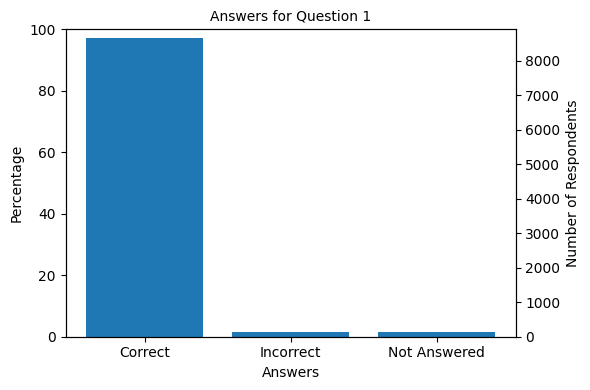

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = merged  # Your merged DataFrame

# Code-to-label map
label_map = {1: "Correct", 2: "Partially Correct", 5: "Incorrect", 9: "Not Answered"}

# Filter answered responses
answered = df[df["WB16K1"].notna()]
counts = answered["WB16K1"].value_counts(dropna=False).sort_index()
mapped_index = pd.Series(counts.index).map(label_map).fillna("Other")
counts.index = mapped_index

# Compute percentages
percentages = counts / counts.sum() * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))

# Left Y-axis: Percent
bars = ax1.bar(counts.index, percentages)
ax1.set_ylabel("Percentage", fontsize=10)
ax1.set_ylim(0, 100)

# Right Y-axis: Raw counts
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Respondents", fontsize=10)
ax2.set_ylim(0, counts.max() * 1.1)  # Align scale with bars

plt.title("Answers for Question 1", fontsize=10)
ax1.set_xlabel("Answers")
plt.tight_layout()
plt.show()


**The vast majority of respondents answered Question 1 correctly, with very few providing incorrect answers or leaving it blank. This suggests the question was clearly understood and likely perceived as straightforward or easy.**

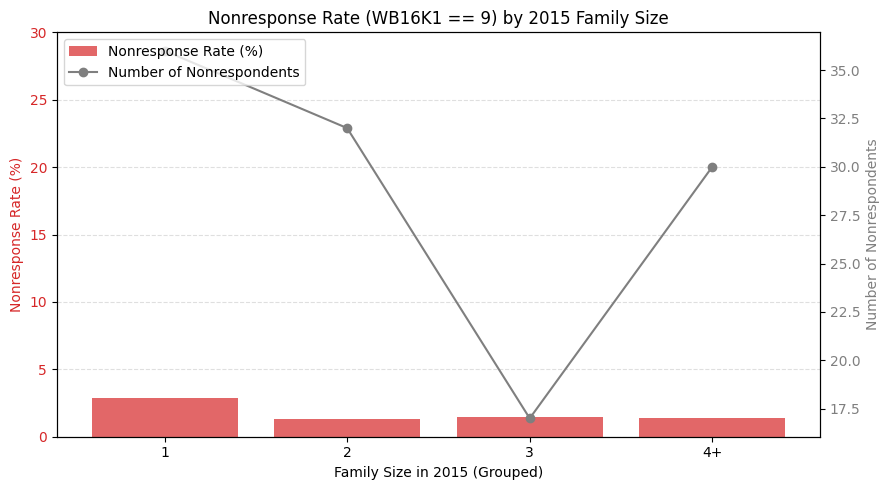

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: 2016 individuals with a known 2015 family link
df_2016 = merged[merged["year"] == 2016].copy()
df_2016 = df_2016[df_2016["family_id"].notna()]  # only those linked to 2015
df_2016 = df_2016.copy()

# STEP 2: Flag nonrespondents as WB16K6 == 9
df_2016["nonresponse"] = (df_2016["WB16K1"] == 9)

# STEP 3: Count eligible and nonresponses per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# STEP 4: Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 5: Get 2015 family size using ER34301
df_2015 = merged[merged["year"] == 2015].copy()
family_sizes = df_2015.groupby("ER34301").size().reset_index(name="family_size")
summary = summary.merge(family_sizes, left_on="family_id", right_on="ER34301", how="left")

# STEP 6: Bin 2015 family size
def bin_size(n):
    if n == 1: return "1"
    elif n == 2: return "2"
    elif n == 3: return "3"
    else: return "4+"
summary["size_group"] = summary["family_size"].apply(bin_size)

# STEP 7: Aggregate for plot
grouped = summary.groupby("size_group", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 8: Plot
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(9, 5))

# Left axis: nonresponse rate (%) — bars
bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)  # Lowered percent scale
ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)

# Right axis: number of nonrespondents — line
ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

# X-axis
plt.xticks(x, grouped["size_group"])
ax1.set_xlabel("Family Size in 2015 (Grouped)")

# Title and legend
plt.title("Nonresponse Rate (WB16K1 == 9) by 2015 Family Size")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper left")
plt.tight_layout()
plt.show()


**Nonresponse rates remain low across all family sizes, with only slight variation. This suggests that family size in 2015 had minimal impact on the likelihood of not responding to this question.**

/tmp/ipython-input-5-1144654676.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)


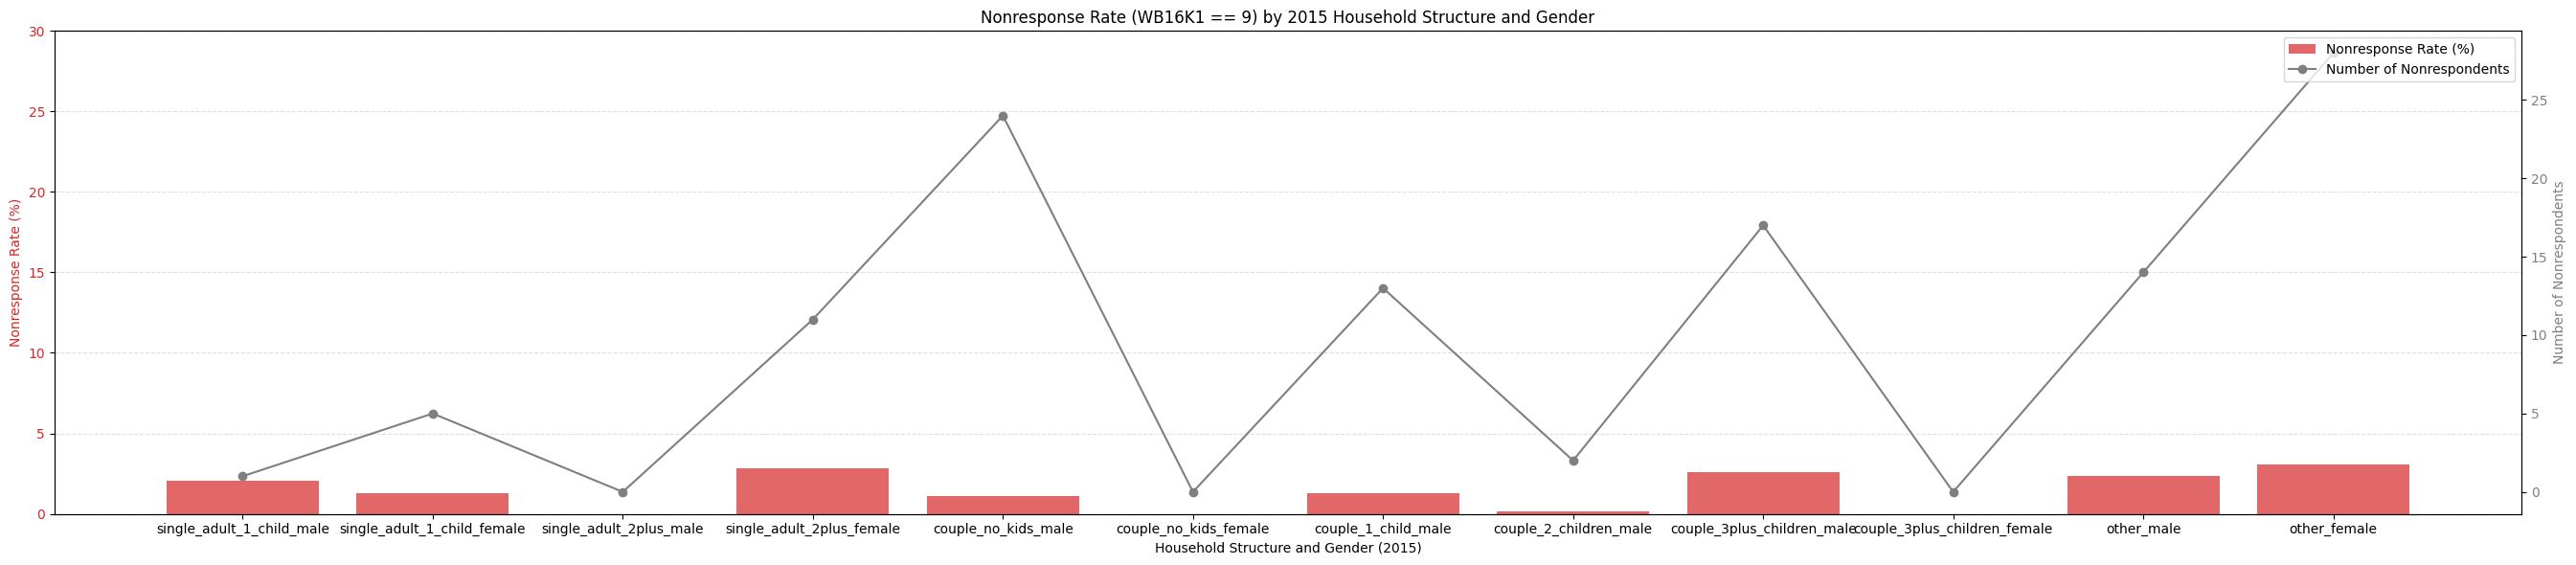

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: Build household structure from 2015
df_2015 = merged[merged["year"] == 2015][["ER34301", "ER34303", "ER32000"]].copy()
df_2015 = df_2015.rename(columns={"ER34301": "wave15_id", "ER34303": "REL", "ER32000": "SEX"})
df_2015["REL"] = pd.to_numeric(df_2015["REL"], errors="coerce").fillna(0).astype(int)
df_2015["SEX"] = pd.to_numeric(df_2015["SEX"], errors="coerce").fillna(0).astype(int)

g = df_2015.groupby("wave15_id")
hh = pd.DataFrame({
    "size": g.size(),
    "spouse": g["REL"].apply(lambda s: any(r in (20, 22) for r in s)),
    "children": g["REL"].apply(lambda s: sum(r in (30, 33, 35) for r in s)),
    "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)
})

def classify(row):
    if row.size == 1: return "single_adult"
    if row.spouse:
        if row.children == 0: return "couple_no_kids"
        if row.children == 1: return "couple_1_child"
        if row.children == 2: return "couple_2_children"
        return "couple_3plus_children"
    if row.children == 1: return "single_adult_1_child"
    if row.children >= 2: return "single_adult_2plus"
    return "other"

hh["structure"] = hh.apply(classify, axis=1)
hh["gender"] = hh["head_sex"].map({1: "male", 2: "female"})
hh["structure_gender"] = hh["structure"] + "_" + hh["gender"]
hh = hh.reset_index()

# STEP 2: 2016 responses (nonresponse = WB16K6 == 9)
df_2016 = merged[merged["year"] == 2016][["family_id", "WB16K1"]].copy()
df_2016 = df_2016.dropna(subset=["family_id"])
df_2016["nonresponse"] = df_2016["WB16K1"] == 9

# Count number of eligible and nonrespondents per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 3: Merge structure + gender
summary = summary.merge(hh[["wave15_id", "structure_gender"]], left_on="family_id", right_on="wave15_id", how="inner")

# STEP 4: Aggregate by structure+gender group
grouped = summary.groupby("structure_gender", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 5: Sort for prettier display (optional)
order = [s + "_" + g for s in [
    "single_adult", "single_adult_1_child", "single_adult_2plus",
    "couple_no_kids", "couple_1_child", "couple_2_children",
    "couple_3plus_children", "other"
] for g in ["male", "female"] if s + "_" + g in grouped["structure_gender"].values]
grouped = grouped.set_index("structure_gender").loc[order].reset_index()

# STEP 6: Plot
x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(27, 6))

bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)
ax1.grid(True, axis='y', linestyle="--", alpha=0.4)

ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

plt.xticks(x, grouped["structure_gender"], rotation=45, ha="right")
ax1.set_xlabel("Household Structure and Gender (2015)")
plt.title("Nonresponse Rate by 2015 Household Structure and Gender")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper right")
plt.tight_layout()

plt.show()


##Question 2 : "WB16K2" , A shop is having a half-price (50% off) sale. Before the sale, a sofa costs $300. How much will it cost on sale?

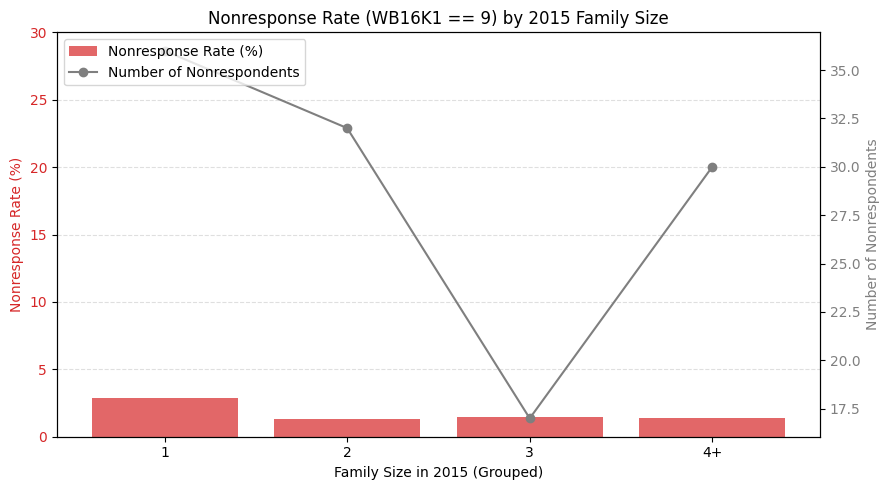

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: 2016 individuals with a known 2015 family link
df_2016 = merged[merged["year"] == 2016].copy()
df_2016 = df_2016[df_2016["family_id"].notna()]  # only those linked to 2015
df_2016 = df_2016.copy()

# STEP 2: Flag nonrespondents as WB16K6 == 9
df_2016["nonresponse"] = (df_2016["WB16K1"] == 9)

# STEP 3: Count eligible and nonresponses per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# STEP 4: Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 5: Get 2015 family size using ER34301
df_2015 = merged[merged["year"] == 2015].copy()
family_sizes = df_2015.groupby("ER34301").size().reset_index(name="family_size")
summary = summary.merge(family_sizes, left_on="family_id", right_on="ER34301", how="left")

# STEP 6: Bin 2015 family size
def bin_size(n):
    if n == 1: return "1"
    elif n == 2: return "2"
    elif n == 3: return "3"
    else: return "4+"
summary["size_group"] = summary["family_size"].apply(bin_size)

# STEP 7: Aggregate for plot
grouped = summary.groupby("size_group", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 8: Plot
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(9, 5))

# Left axis: nonresponse rate (%) — bars
bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)  # Lowered percent scale
ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)

# Right axis: number of nonrespondents — line
ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

# X-axis
plt.xticks(x, grouped["size_group"])
ax1.set_xlabel("Family Size in 2015 (Grouped)")

# Title and legend
plt.title("Nonresponse Rate by 2015 Family Size")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper left")
plt.tight_layout()
plt.show()


**The figure shows that nonresponse rates are consistently low across different family sizes, with only minor fluctuations. This indicates that family size does not significantly influence the likelihood of nonresponse for this question**

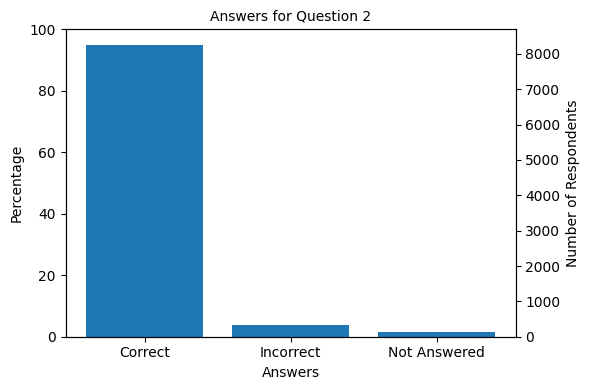

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = merged  # Your merged DataFrame

# Code-to-label map
label_map = {1: "Correct", 2: "Partially Correct", 5: "Incorrect", 9: "Not Answered"}

# Filter answered responses
answered = df[df["WB16K2"].notna()]
counts = answered["WB16K2"].value_counts(dropna=False).sort_index()
mapped_index = pd.Series(counts.index).map(label_map).fillna("Other")
counts.index = mapped_index

# Compute percentages
percentages = counts / counts.sum() * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))

# Left Y-axis: Percent
bars = ax1.bar(counts.index, percentages)
ax1.set_ylabel("Percentage", fontsize=10)
ax1.set_ylim(0, 100)

# Right Y-axis: Raw counts
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Respondents", fontsize=10)
ax2.set_ylim(0, counts.max() * 1.1)  # Align scale with bars

plt.title("Answers for Question 2", fontsize=10)
ax1.set_xlabel("Answers")
plt.tight_layout()
plt.show()


**Most respondents answered Question 2 correctly, with a small portion selecting incorrect answers or skipping the question. This suggests that the question was generally well-understood but slightly more challenging than Question 1.**

/tmp/ipython-input-8-1594842684.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)


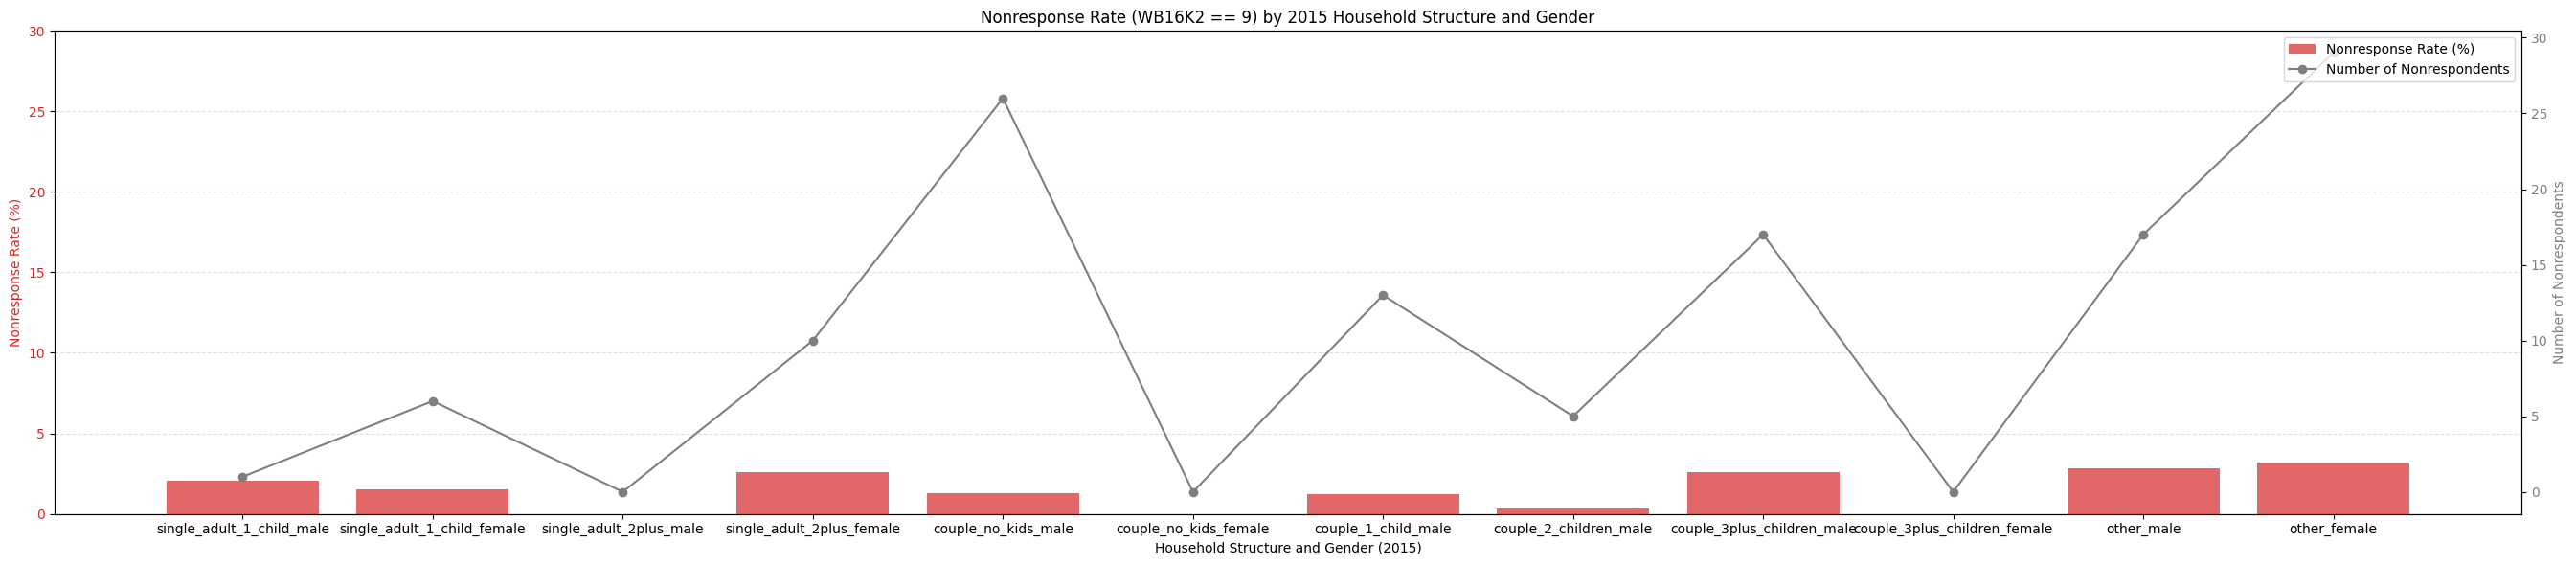

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: Build household structure from 2015
df_2015 = merged[merged["year"] == 2015][["ER34301", "ER34303", "ER32000"]].copy()
df_2015 = df_2015.rename(columns={"ER34301": "wave15_id", "ER34303": "REL", "ER32000": "SEX"})
df_2015["REL"] = pd.to_numeric(df_2015["REL"], errors="coerce").fillna(0).astype(int)
df_2015["SEX"] = pd.to_numeric(df_2015["SEX"], errors="coerce").fillna(0).astype(int)

g = df_2015.groupby("wave15_id")
hh = pd.DataFrame({
    "size": g.size(),
    "spouse": g["REL"].apply(lambda s: any(r in (20, 22) for r in s)),
    "children": g["REL"].apply(lambda s: sum(r in (30, 33, 35) for r in s)),
    "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)
})

def classify(row):
    if row.size == 1: return "single_adult"
    if row.spouse:
        if row.children == 0: return "couple_no_kids"
        if row.children == 1: return "couple_1_child"
        if row.children == 2: return "couple_2_children"
        return "couple_3plus_children"
    if row.children == 1: return "single_adult_1_child"
    if row.children >= 2: return "single_adult_2plus"
    return "other"

hh["structure"] = hh.apply(classify, axis=1)
hh["gender"] = hh["head_sex"].map({1: "male", 2: "female"})
hh["structure_gender"] = hh["structure"] + "_" + hh["gender"]
hh = hh.reset_index()

# STEP 2: 2016 responses (nonresponse = WB16K6 == 9)
df_2016 = merged[merged["year"] == 2016][["family_id", "WB16K2"]].copy()
df_2016 = df_2016.dropna(subset=["family_id"])
df_2016["nonresponse"] = df_2016["WB16K2"] == 9

# Count number of eligible and nonrespondents per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 3: Merge structure + gender
summary = summary.merge(hh[["wave15_id", "structure_gender"]], left_on="family_id", right_on="wave15_id", how="inner")

# STEP 4: Aggregate by structure+gender group
grouped = summary.groupby("structure_gender", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 5: Sort for prettier display (optional)
order = [s + "_" + g for s in [
    "single_adult", "single_adult_1_child", "single_adult_2plus",
    "couple_no_kids", "couple_1_child", "couple_2_children",
    "couple_3plus_children", "other"
] for g in ["male", "female"] if s + "_" + g in grouped["structure_gender"].values]
grouped = grouped.set_index("structure_gender").loc[order].reset_index()

# STEP 6: Plot
x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(27, 6))

bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)
ax1.grid(True, axis='y', linestyle="--", alpha=0.4)

ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

plt.xticks(x, grouped["structure_gender"], rotation=45, ha="right")
ax1.set_xlabel("Household Structure and Gender (2015)")
plt.title("Nonresponse Rate by 2015 Household Structure and Gender")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper right")
plt.tight_layout()

plt.show()


##Question 3 :"WB16K3", , If the chance of getting a disease is 10 percent, how many people out of 1,000 would be expected to get the disease?



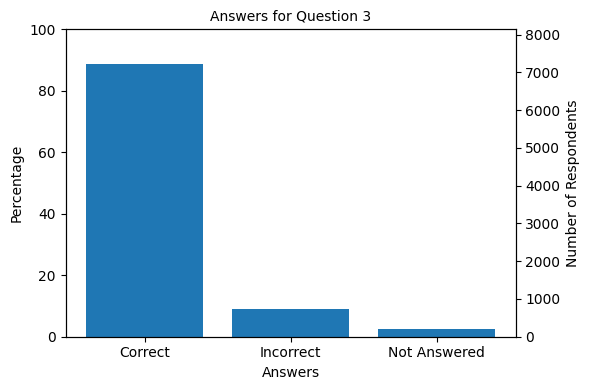

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = merged  # Your merged DataFrame

# Code-to-label map
label_map = {1: "Correct", 2: "Partially Correct", 5: "Incorrect", 9: "Not Answered"}

# Filter answered responses
answered = df[df["WB16K3"].notna()]
counts = answered["WB16K3"].value_counts(dropna=False).sort_index()
mapped_index = pd.Series(counts.index).map(label_map).fillna("Other")
counts.index = mapped_index

# Compute percentages
percentages = counts / counts.sum() * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))

# Left Y-axis: Percent
bars = ax1.bar(counts.index, percentages)
ax1.set_ylabel("Percentage", fontsize=10)
ax1.set_ylim(0, 100)

# Right Y-axis: Raw counts
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Respondents", fontsize=10)
ax2.set_ylim(0, counts.max() * 1.1)  # Align scale with bars

plt.title("Answers for Question 3", fontsize=10)
ax1.set_xlabel("Answers")
plt.tight_layout()
plt.show()


**Question 3 had a slightly lower correct response rate compared to earlier questions, with more incorrect answers and nonresponses. This suggests the question may have been more difficult or less clearly understood**

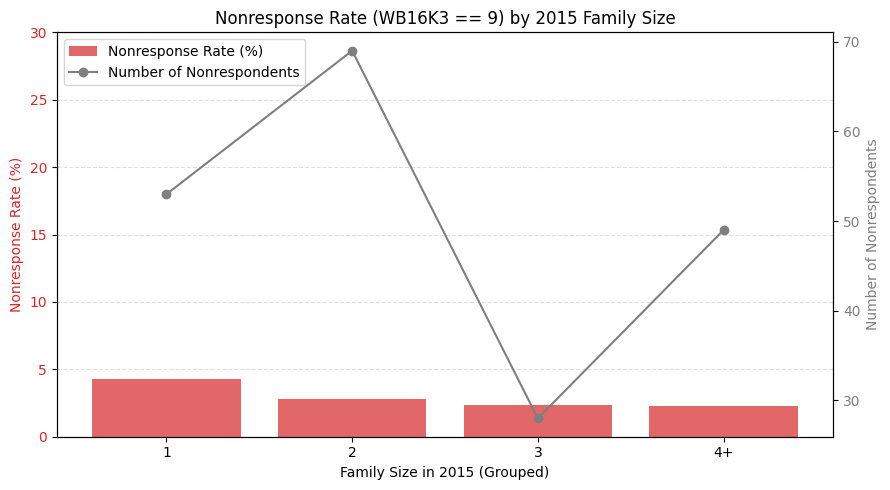

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: 2016 individuals with a known 2015 family link
df_2016 = merged[merged["year"] == 2016].copy()
df_2016 = df_2016[df_2016["family_id"].notna()]  # only those linked to 2015
df_2016 = df_2016.copy()

# STEP 2: Flag nonrespondents as WB16K6 == 9
df_2016["nonresponse"] = (df_2016["WB16K3"] == 9)

# STEP 3: Count eligible and nonresponses per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# STEP 4: Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 5: Get 2015 family size using ER34301
df_2015 = merged[merged["year"] == 2015].copy()
family_sizes = df_2015.groupby("ER34301").size().reset_index(name="family_size")
summary = summary.merge(family_sizes, left_on="family_id", right_on="ER34301", how="left")

# STEP 6: Bin 2015 family size
def bin_size(n):
    if n == 1: return "1"
    elif n == 2: return "2"
    elif n == 3: return "3"
    else: return "4+"
summary["size_group"] = summary["family_size"].apply(bin_size)

# STEP 7: Aggregate for plot
grouped = summary.groupby("size_group", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 8: Plot
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(9, 5))

# Left axis: nonresponse rate (%) — bars
bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)  # Lowered percent scale
ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)

# Right axis: number of nonrespondents — line
ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

# X-axis
plt.xticks(x, grouped["size_group"])
ax1.set_xlabel("Family Size in 2015 (Grouped)")

# Title and legend
plt.title("Nonresponse Rate by 2015 Family Size")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper left")
plt.tight_layout()
plt.show()


**Nonresponse rates for this question remain low across all family sizes, with only modest variation. This pattern suggests that family size in 2015 did not substantially influence the likelihood of skipping or refusing to answer**

/tmp/ipython-input-11-828547090.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)


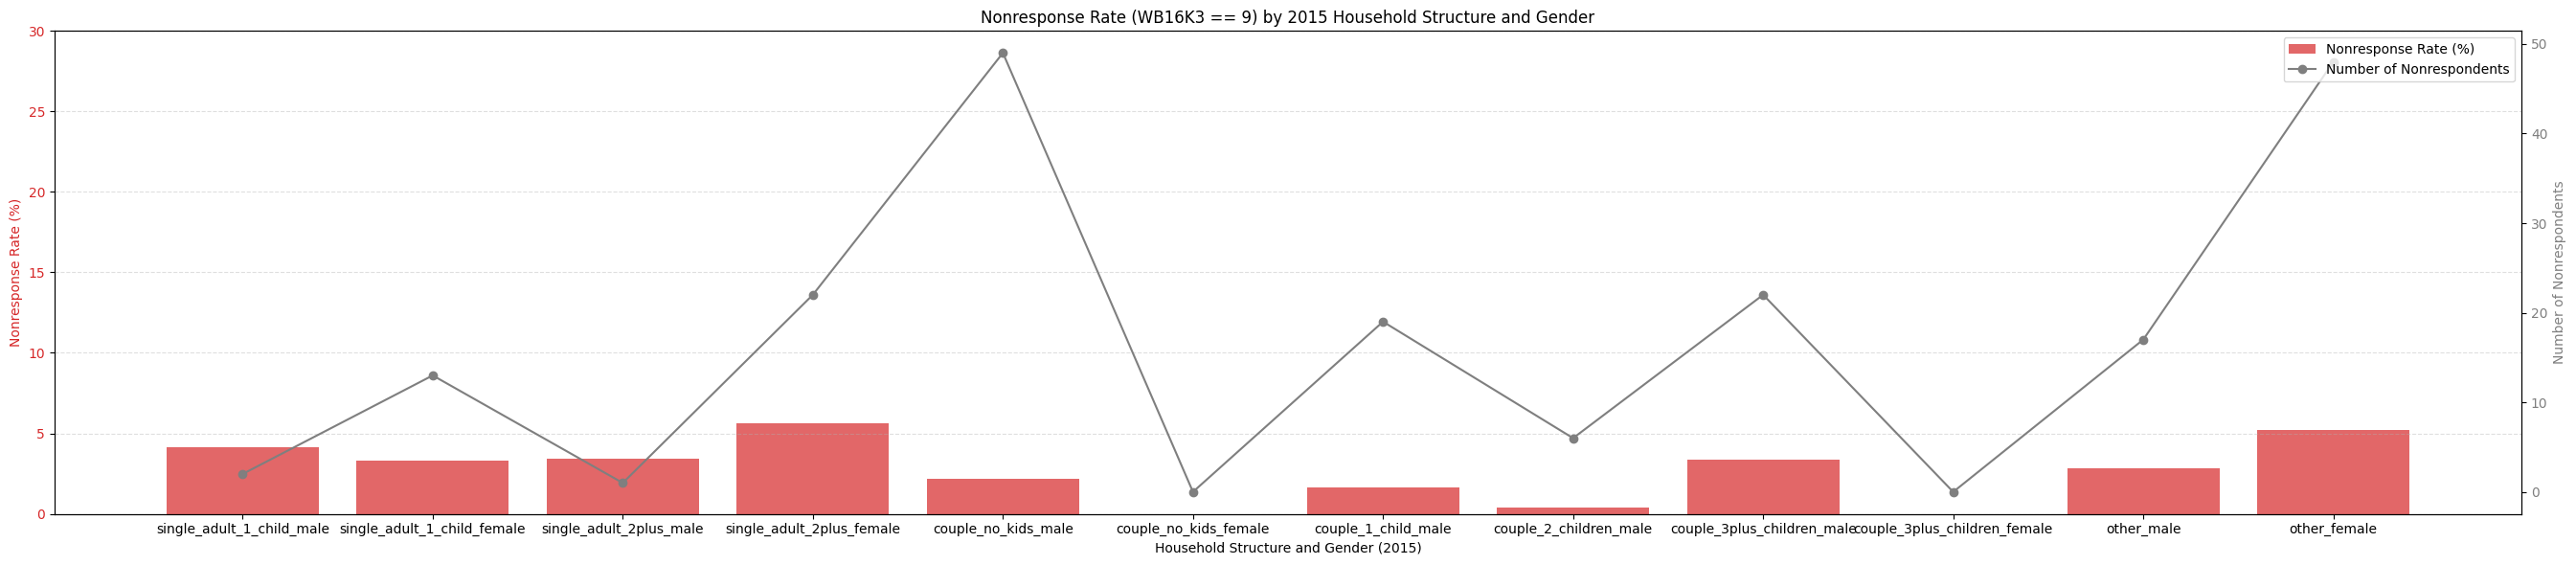

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: Build household structure from 2015
df_2015 = merged[merged["year"] == 2015][["ER34301", "ER34303", "ER32000"]].copy()
df_2015 = df_2015.rename(columns={"ER34301": "wave15_id", "ER34303": "REL", "ER32000": "SEX"})
df_2015["REL"] = pd.to_numeric(df_2015["REL"], errors="coerce").fillna(0).astype(int)
df_2015["SEX"] = pd.to_numeric(df_2015["SEX"], errors="coerce").fillna(0).astype(int)

g = df_2015.groupby("wave15_id")
hh = pd.DataFrame({
    "size": g.size(),
    "spouse": g["REL"].apply(lambda s: any(r in (20, 22) for r in s)),
    "children": g["REL"].apply(lambda s: sum(r in (30, 33, 35) for r in s)),
    "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)
})

def classify(row):
    if row.size == 1: return "single_adult"
    if row.spouse:
        if row.children == 0: return "couple_no_kids"
        if row.children == 1: return "couple_1_child"
        if row.children == 2: return "couple_2_children"
        return "couple_3plus_children"
    if row.children == 1: return "single_adult_1_child"
    if row.children >= 2: return "single_adult_2plus"
    return "other"

hh["structure"] = hh.apply(classify, axis=1)
hh["gender"] = hh["head_sex"].map({1: "male", 2: "female"})
hh["structure_gender"] = hh["structure"] + "_" + hh["gender"]
hh = hh.reset_index()

# STEP 2: 2016 responses (nonresponse = WB16K6 == 9)
df_2016 = merged[merged["year"] == 2016][["family_id", "WB16K3"]].copy()
df_2016 = df_2016.dropna(subset=["family_id"])
df_2016["nonresponse"] = df_2016["WB16K3"] == 9

# Count number of eligible and nonrespondents per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 3: Merge structure + gender
summary = summary.merge(hh[["wave15_id", "structure_gender"]], left_on="family_id", right_on="wave15_id", how="inner")

# STEP 4: Aggregate by structure+gender group
grouped = summary.groupby("structure_gender", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 5: Sort for prettier display (optional)
order = [s + "_" + g for s in [
    "single_adult", "single_adult_1_child", "single_adult_2plus",
    "couple_no_kids", "couple_1_child", "couple_2_children",
    "couple_3plus_children", "other"
] for g in ["male", "female"] if s + "_" + g in grouped["structure_gender"].values]
grouped = grouped.set_index("structure_gender").loc[order].reset_index()

# STEP 6: Plot
x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(27, 6))

bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)
ax1.grid(True, axis='y', linestyle="--", alpha=0.4)

ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

plt.xticks(x, grouped["structure_gender"], rotation=45, ha="right")
ax1.set_xlabel("Household Structure and Gender (2015)")
plt.title("Nonresponse Rate by 2015 Household Structure and Gender")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper right")
plt.tight_layout()

plt.show()


##Question 4 : "WB16K4", A used car dealer is selling a car for $6,000. This is two thirds of what it cost new. How much did the car cost new?



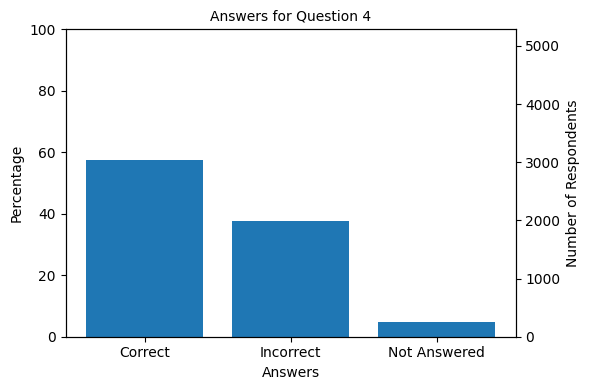

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = merged  # Your merged DataFrame

# Code-to-label map
label_map = {1: "Correct", 2: "Partially Correct", 5: "Incorrect", 9: "Not Answered"}

# Filter answered responses
answered = df[df["WB16K4"].notna()]
counts = answered["WB16K4"].value_counts(dropna=False).sort_index()
mapped_index = pd.Series(counts.index).map(label_map).fillna("Other")
counts.index = mapped_index

# Compute percentages
percentages = counts / counts.sum() * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))

# Left Y-axis: Percent
bars = ax1.bar(counts.index, percentages)
ax1.set_ylabel("Percentage", fontsize=10)
ax1.set_ylim(0, 100)

# Right Y-axis: Raw counts
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Respondents", fontsize=10)
ax2.set_ylim(0, counts.max() * 1.1)  # Align scale with bars

plt.title("Answers for Question 4", fontsize=10)
ax1.set_xlabel("Answers")
plt.tight_layout()
plt.show()


**Question 4 had a noticeably lower correct response rate compared to earlier questions, with a significant portion of incorrect answers. This suggests the question was more challenging or possibly less clearly understood by respondents**

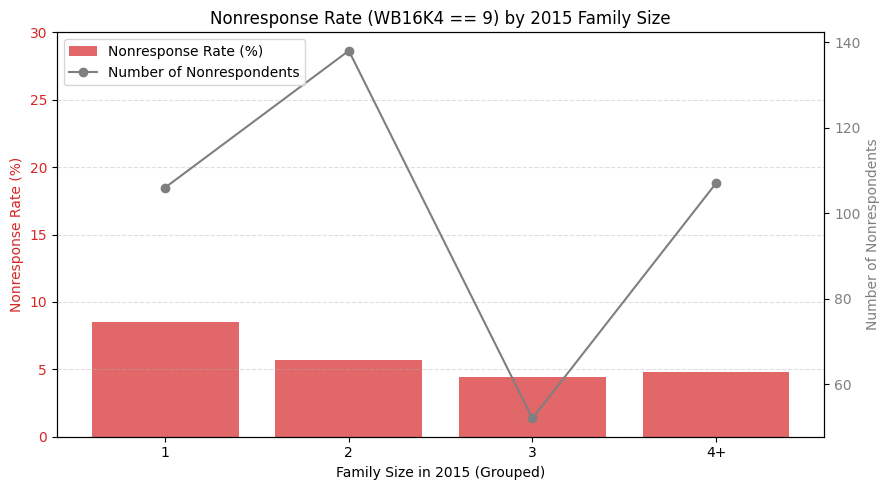

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: 2016 individuals with a known 2015 family link
df_2016 = merged[merged["year"] == 2016].copy()
df_2016 = df_2016[df_2016["family_id"].notna()]  # only those linked to 2015
df_2016 = df_2016.copy()

# STEP 2: Flag nonrespondents as WB16K6 == 9
df_2016["nonresponse"] = (df_2016["WB16K4"] == 9)

# STEP 3: Count eligible and nonresponses per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# STEP 4: Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 5: Get 2015 family size using ER34301
df_2015 = merged[merged["year"] == 2015].copy()
family_sizes = df_2015.groupby("ER34301").size().reset_index(name="family_size")
summary = summary.merge(family_sizes, left_on="family_id", right_on="ER34301", how="left")

# STEP 6: Bin 2015 family size
def bin_size(n):
    if n == 1: return "1"
    elif n == 2: return "2"
    elif n == 3: return "3"
    else: return "4+"
summary["size_group"] = summary["family_size"].apply(bin_size)

# STEP 7: Aggregate for plot
grouped = summary.groupby("size_group", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 8: Plot
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(9, 5))

# Left axis: nonresponse rate (%) — bars
bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)  # Lowered percent scale
ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)

# Right axis: number of nonrespondents — line
ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

# X-axis
plt.xticks(x, grouped["size_group"])
ax1.set_xlabel("Family Size in 2015 (Grouped)")

# Title and legend
plt.title("Nonresponse Rate by 2015 Family Size")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper left")
plt.tight_layout()
plt.show()


**Nonresponse rates for this question are low across all family sizes, with only slight variation. This suggests that family size did not significantly affect respondents' likelihood of answering this item**

/tmp/ipython-input-14-3809290866.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)


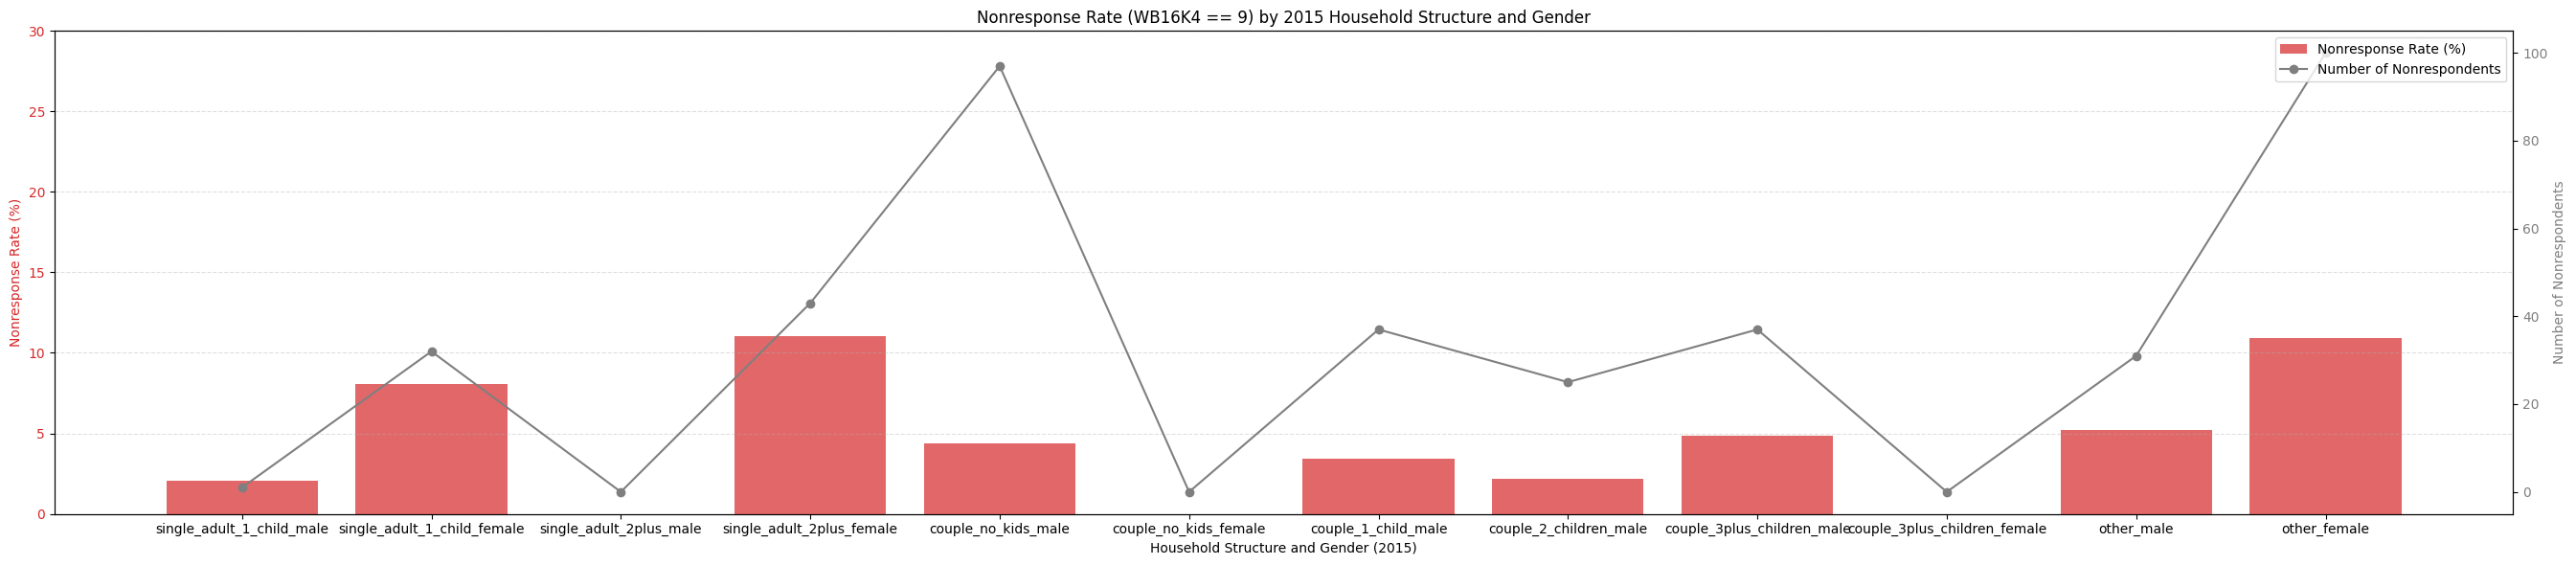

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: Build household structure from 2015
df_2015 = merged[merged["year"] == 2015][["ER34301", "ER34303", "ER32000"]].copy()
df_2015 = df_2015.rename(columns={"ER34301": "wave15_id", "ER34303": "REL", "ER32000": "SEX"})
df_2015["REL"] = pd.to_numeric(df_2015["REL"], errors="coerce").fillna(0).astype(int)
df_2015["SEX"] = pd.to_numeric(df_2015["SEX"], errors="coerce").fillna(0).astype(int)

g = df_2015.groupby("wave15_id")
hh = pd.DataFrame({
    "size": g.size(),
    "spouse": g["REL"].apply(lambda s: any(r in (20, 22) for r in s)),
    "children": g["REL"].apply(lambda s: sum(r in (30, 33, 35) for r in s)),
    "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)
})

def classify(row):
    if row.size == 1: return "single_adult"
    if row.spouse:
        if row.children == 0: return "couple_no_kids"
        if row.children == 1: return "couple_1_child"
        if row.children == 2: return "couple_2_children"
        return "couple_3plus_children"
    if row.children == 1: return "single_adult_1_child"
    if row.children >= 2: return "single_adult_2plus"
    return "other"

hh["structure"] = hh.apply(classify, axis=1)
hh["gender"] = hh["head_sex"].map({1: "male", 2: "female"})
hh["structure_gender"] = hh["structure"] + "_" + hh["gender"]
hh = hh.reset_index()

# STEP 2: 2016 responses (nonresponse = WB16K6 == 9)
df_2016 = merged[merged["year"] == 2016][["family_id", "WB16K4"]].copy()
df_2016 = df_2016.dropna(subset=["family_id"])
df_2016["nonresponse"] = df_2016["WB16K4"] == 9

# Count number of eligible and nonrespondents per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 3: Merge structure + gender
summary = summary.merge(hh[["wave15_id", "structure_gender"]], left_on="family_id", right_on="wave15_id", how="inner")

# STEP 4: Aggregate by structure+gender group
grouped = summary.groupby("structure_gender", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 5: Sort for prettier display (optional)
order = [s + "_" + g for s in [
    "single_adult", "single_adult_1_child", "single_adult_2plus",
    "couple_no_kids", "couple_1_child", "couple_2_children",
    "couple_3plus_children", "other"
] for g in ["male", "female"] if s + "_" + g in grouped["structure_gender"].values]
grouped = grouped.set_index("structure_gender").loc[order].reset_index()

# STEP 6: Plot
x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(27, 6))

bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)
ax1.grid(True, axis='y', linestyle="--", alpha=0.4)

ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

plt.xticks(x, grouped["structure_gender"], rotation=45, ha="right")
ax1.set_xlabel("Household Structure and Gender (2015)")
plt.title("Nonresponse Rate by 2015 Household Structure and Gender")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper right")
plt.tight_layout()

plt.show()


##Question 5 : "WB16K5", If 5 people all have the winning numbers in the lottery and the prize is $2 million, how much will each of them get?



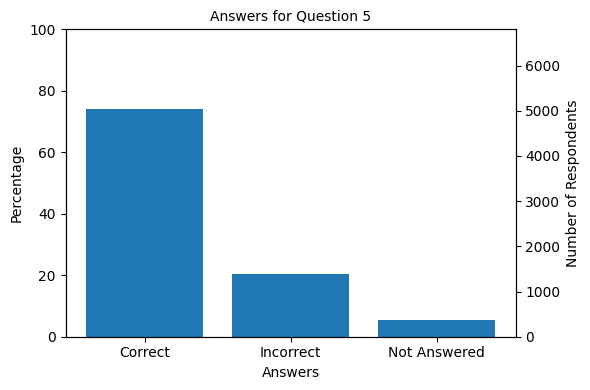

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = merged  # Your merged DataFrame

# Code-to-label map
label_map = {1: "Correct", 2: "Partially Correct", 5: "Incorrect", 9: "Not Answered"}

# Filter answered responses
answered = df[df["WB16K5"].notna()]
counts = answered["WB16K5"].value_counts(dropna=False).sort_index()
mapped_index = pd.Series(counts.index).map(label_map).fillna("Other")
counts.index = mapped_index

# Compute percentages
percentages = counts / counts.sum() * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))

# Left Y-axis: Percent
bars = ax1.bar(counts.index, percentages)
ax1.set_ylabel("Percentage", fontsize=10)
ax1.set_ylim(0, 100)

# Right Y-axis: Raw counts
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Respondents", fontsize=10)
ax2.set_ylim(0, counts.max() * 1.1)  # Align scale with bars

plt.title("Answers for Question 5", fontsize=10)
ax1.set_xlabel("Answers")
plt.tight_layout()
plt.show()


**A majority of respondents answered Question 5 correctly, though the incorrect response rate is higher than in previous questions. This may indicate increased difficulty or a higher chance of confusion among participants**

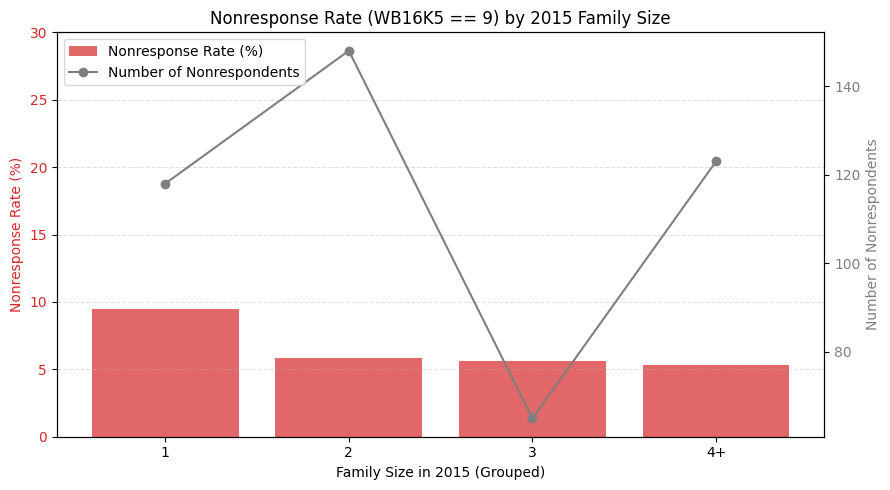

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: 2016 individuals with a known 2015 family link
df_2016 = merged[merged["year"] == 2016].copy()
df_2016 = df_2016[df_2016["family_id"].notna()]  # only those linked to 2015
df_2016 = df_2016.copy()

# STEP 2: Flag nonrespondents as WB16K6 == 9
df_2016["nonresponse"] = (df_2016["WB16K5"] == 9)

# STEP 3: Count eligible and nonresponses per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# STEP 4: Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 5: Get 2015 family size using ER34301
df_2015 = merged[merged["year"] == 2015].copy()
family_sizes = df_2015.groupby("ER34301").size().reset_index(name="family_size")
summary = summary.merge(family_sizes, left_on="family_id", right_on="ER34301", how="left")

# STEP 6: Bin 2015 family size
def bin_size(n):
    if n == 1: return "1"
    elif n == 2: return "2"
    elif n == 3: return "3"
    else: return "4+"
summary["size_group"] = summary["family_size"].apply(bin_size)

# STEP 7: Aggregate for plot
grouped = summary.groupby("size_group", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 8: Plot
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(9, 5))

# Left axis: nonresponse rate (%) — bars
bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)  # Lowered percent scale
ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)

# Right axis: number of nonrespondents — line
ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

# X-axis
plt.xticks(x, grouped["size_group"])
ax1.set_xlabel("Family Size in 2015 (Grouped)")

# Title and legend
plt.title("Nonresponse Rate (WB16K5 == 9) by 2015 Family Size")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper left")
plt.tight_layout()
plt.show()


**Nonresponse rates for this question remain consistently low across all family sizes, with only small differences. This reinforces the pattern that family size does not play a major role in determining response behavior**

/tmp/ipython-input-17-1997108053.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)


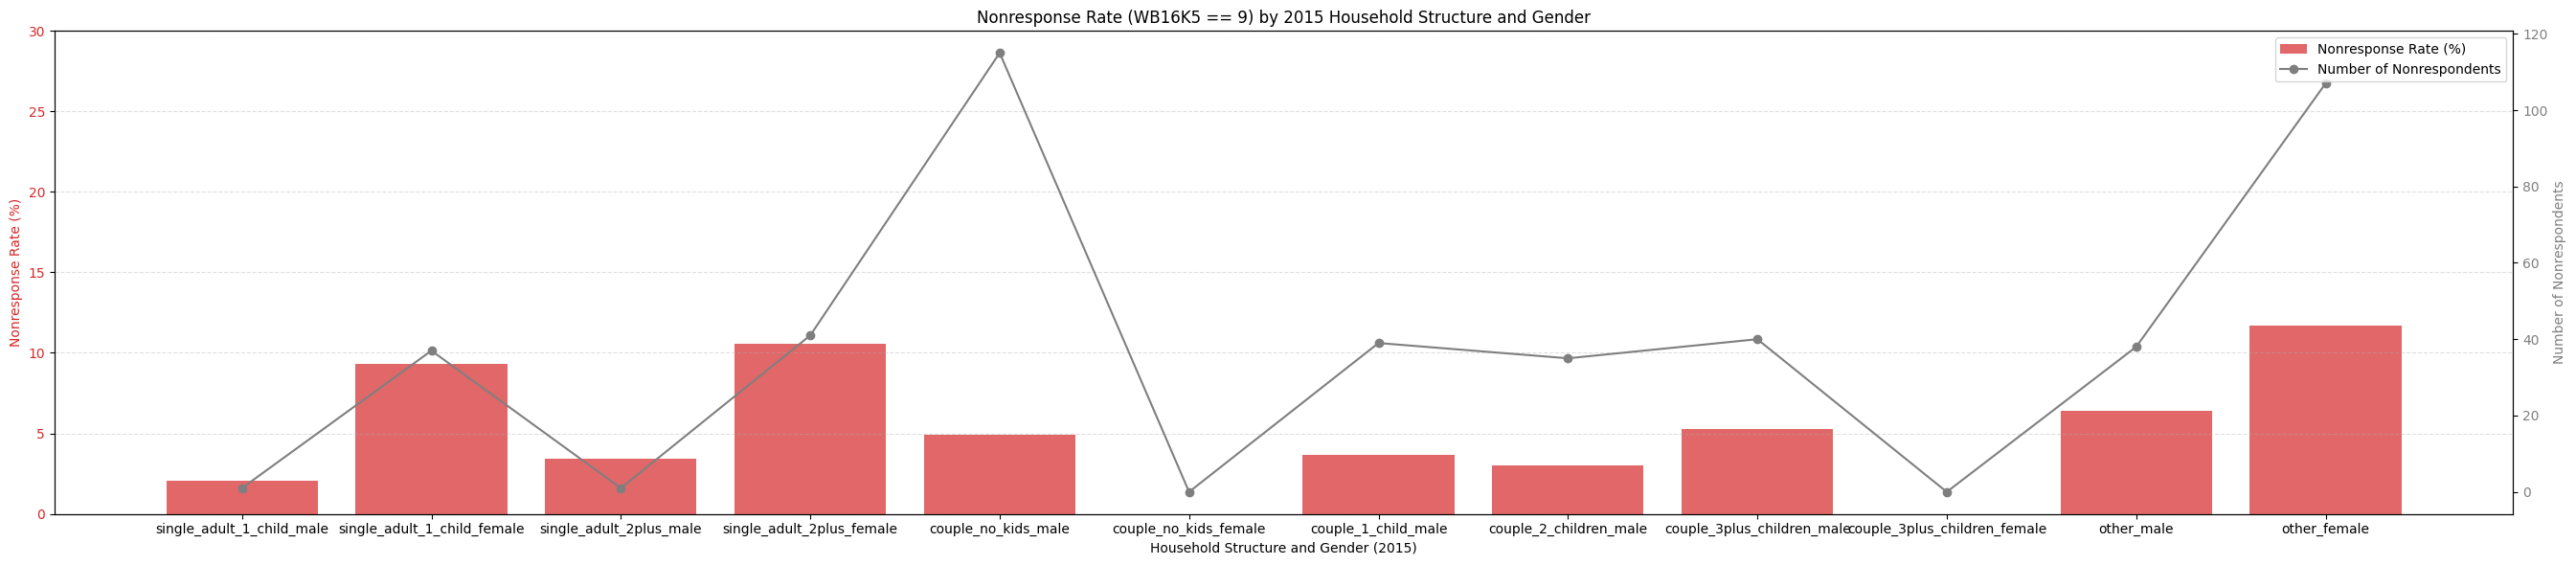

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: Build household structure from 2015
df_2015 = merged[merged["year"] == 2015][["ER34301", "ER34303", "ER32000"]].copy()
df_2015 = df_2015.rename(columns={"ER34301": "wave15_id", "ER34303": "REL", "ER32000": "SEX"})
df_2015["REL"] = pd.to_numeric(df_2015["REL"], errors="coerce").fillna(0).astype(int)
df_2015["SEX"] = pd.to_numeric(df_2015["SEX"], errors="coerce").fillna(0).astype(int)

g = df_2015.groupby("wave15_id")
hh = pd.DataFrame({
    "size": g.size(),
    "spouse": g["REL"].apply(lambda s: any(r in (20, 22) for r in s)),
    "children": g["REL"].apply(lambda s: sum(r in (30, 33, 35) for r in s)),
    "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)
})

def classify(row):
    if row.size == 1: return "single_adult"
    if row.spouse:
        if row.children == 0: return "couple_no_kids"
        if row.children == 1: return "couple_1_child"
        if row.children == 2: return "couple_2_children"
        return "couple_3plus_children"
    if row.children == 1: return "single_adult_1_child"
    if row.children >= 2: return "single_adult_2plus"
    return "other"

hh["structure"] = hh.apply(classify, axis=1)
hh["gender"] = hh["head_sex"].map({1: "male", 2: "female"})
hh["structure_gender"] = hh["structure"] + "_" + hh["gender"]
hh = hh.reset_index()

# STEP 2: 2016 responses (nonresponse = WB16K6 == 9)
df_2016 = merged[merged["year"] == 2016][["family_id", "WB16K5"]].copy()
df_2016 = df_2016.dropna(subset=["family_id"])
df_2016["nonresponse"] = df_2016["WB16K5"] == 9

# Count number of eligible and nonrespondents per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 3: Merge structure + gender
summary = summary.merge(hh[["wave15_id", "structure_gender"]], left_on="family_id", right_on="wave15_id", how="inner")

# STEP 4: Aggregate by structure+gender group
grouped = summary.groupby("structure_gender", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 5: Sort for prettier display (optional)
order = [s + "_" + g for s in [
    "single_adult", "single_adult_1_child", "single_adult_2plus",
    "couple_no_kids", "couple_1_child", "couple_2_children",
    "couple_3plus_children", "other"
] for g in ["male", "female"] if s + "_" + g in grouped["structure_gender"].values]
grouped = grouped.set_index("structure_gender").loc[order].reset_index()

# STEP 6: Plot
x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(27, 6))

bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)
ax1.grid(True, axis='y', linestyle="--", alpha=0.4)

ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

plt.xticks(x, grouped["structure_gender"], rotation=45, ha="right")
ax1.set_xlabel("Household Structure and Gender (2015)")
plt.title("Nonresponse Rate by 2015 Household Structure and Gender")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper right")
plt.tight_layout()

plt.show()


##Question 6 : "WB16K6" , Suppose you have $200 in a savings account. The account earns 10 percent interest each year. How much would you have in the account at the end of two years?



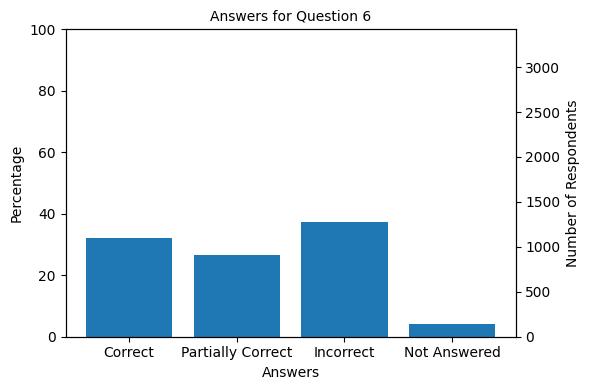

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = merged  # Your merged DataFrame

# Code-to-label map
label_map = {1: "Correct", 2: "Partially Correct", 5: "Incorrect", 9: "Not Answered"}

# Filter answered responses
answered = df[df["WB16K6"].notna()]
counts = answered["WB16K6"].value_counts(dropna=False).sort_index()
mapped_index = pd.Series(counts.index).map(label_map).fillna("Other")
counts.index = mapped_index

# Compute percentages
percentages = counts / counts.sum() * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))

# Left Y-axis: Percent
bars = ax1.bar(counts.index, percentages)
ax1.set_ylabel("Percentage", fontsize=10)
ax1.set_ylim(0, 100)

# Right Y-axis: Raw counts
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Respondents", fontsize=10)
ax2.set_ylim(0, counts.max() * 1.1)  # Align scale with bars

plt.title("Answers for Question 6", fontsize=10)
ax1.set_xlabel("Answers")
plt.tight_layout()
plt.show()


**Question 6 appears to be the most challenging so far, with a relatively low percentage of fully correct answers and a notable share of partially correct and incorrect responses. This suggests the question may have been complex or required multi-step reasoning.**

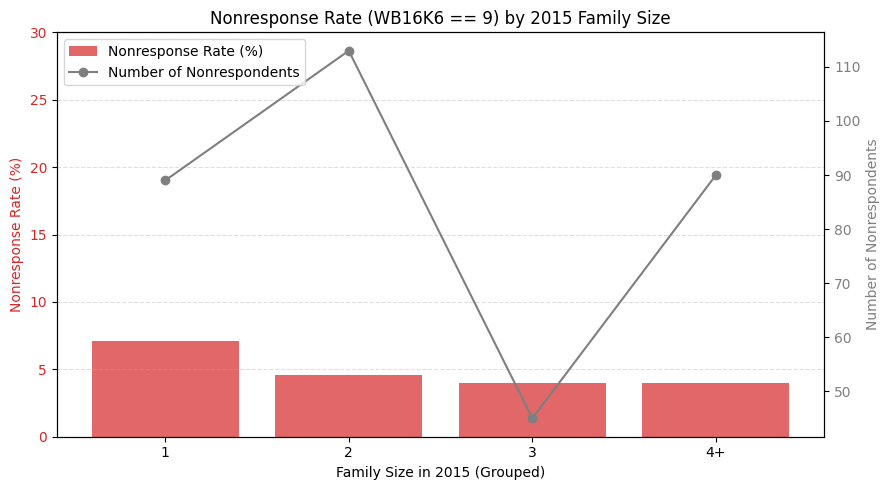

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: 2016 individuals with a known 2015 family link
df_2016 = merged[merged["year"] == 2016].copy()
df_2016 = df_2016[df_2016["family_id"].notna()]  # only those linked to 2015
df_2016 = df_2016.copy()

# STEP 2: Flag nonrespondents as WB16K6 == 9
df_2016["nonresponse"] = (df_2016["WB16K6"] == 9)

# STEP 3: Count eligible and nonresponses per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# STEP 4: Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 5: Get 2015 family size using ER34301
df_2015 = merged[merged["year"] == 2015].copy()
family_sizes = df_2015.groupby("ER34301").size().reset_index(name="family_size")
summary = summary.merge(family_sizes, left_on="family_id", right_on="ER34301", how="left")

# STEP 6: Bin 2015 family size
def bin_size(n):
    if n == 1: return "1"
    elif n == 2: return "2"
    elif n == 3: return "3"
    else: return "4+"
summary["size_group"] = summary["family_size"].apply(bin_size)

# STEP 7: Aggregate for plot
grouped = summary.groupby("size_group", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 8: Plot
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(9, 5))

# Left axis: nonresponse rate (%) — bars
bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)  # Lowered percent scale
ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)

# Right axis: number of nonrespondents — line
ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

# X-axis
plt.xticks(x, grouped["size_group"])
ax1.set_xlabel("Family Size in 2015 (Grouped)")

# Title and legend
plt.title("Nonresponse Rate by 2015 Family Size")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper left")
plt.tight_layout()
plt.show()


**Nonresponse rates for this question are low and relatively stable across all family sizes. This consistent pattern suggests that family size had little to no impact on respondents’ likelihood of skipping the question.**

/tmp/ipython-input-19-1097878331.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)


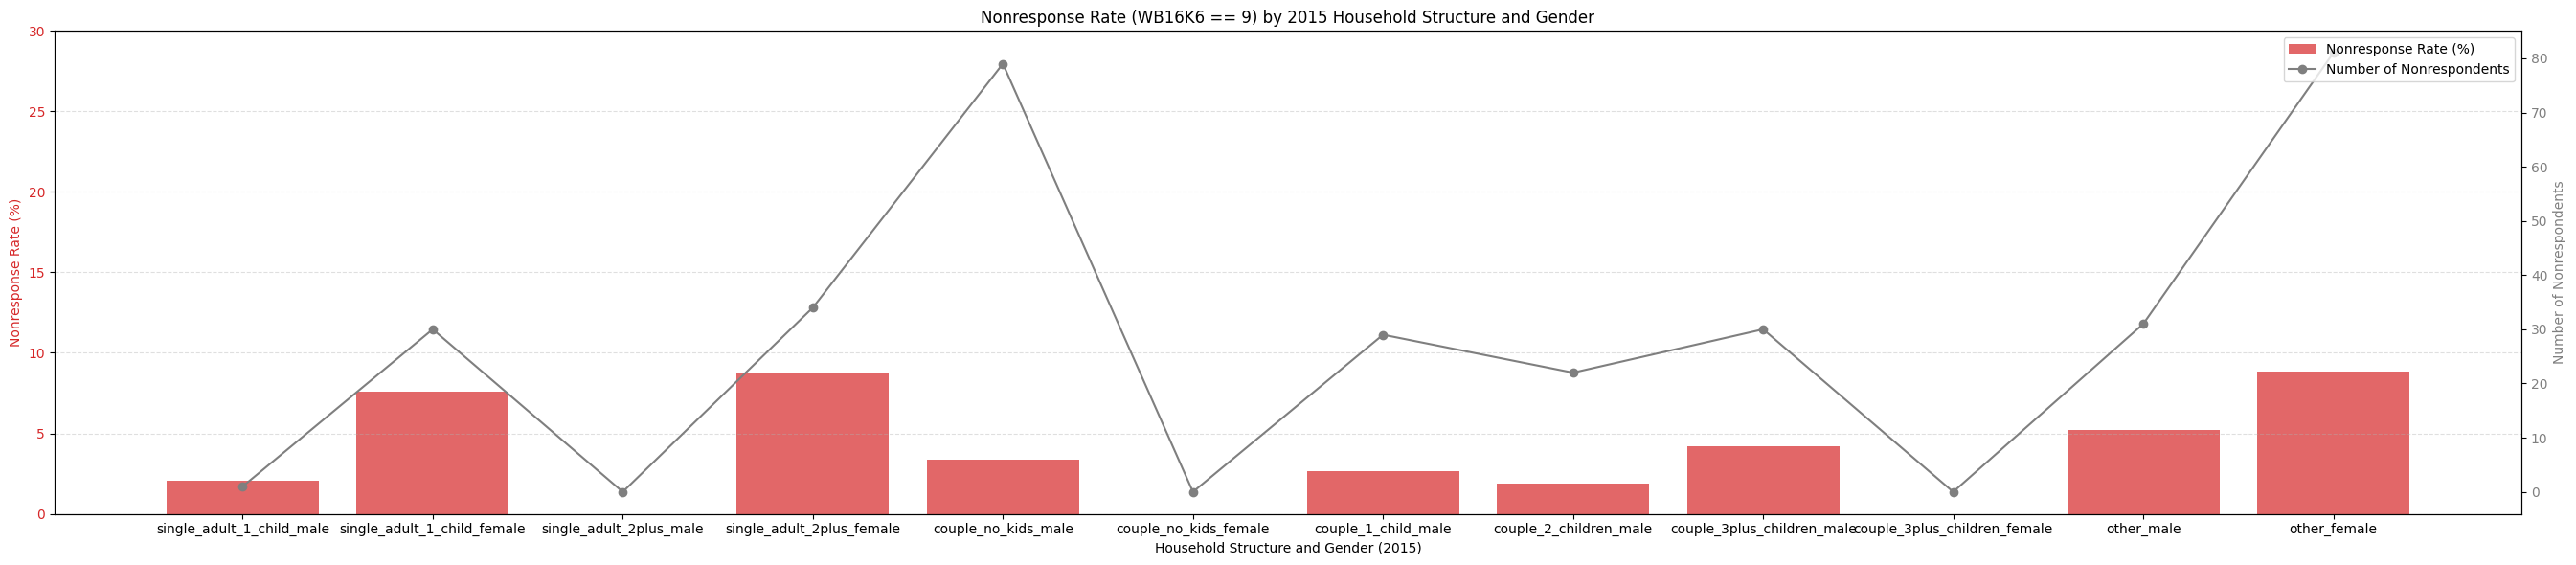

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: Build household structure from 2015
df_2015 = merged[merged["year"] == 2015][["ER34301", "ER34303", "ER32000"]].copy()
df_2015 = df_2015.rename(columns={"ER34301": "wave15_id", "ER34303": "REL", "ER32000": "SEX"})
df_2015["REL"] = pd.to_numeric(df_2015["REL"], errors="coerce").fillna(0).astype(int)
df_2015["SEX"] = pd.to_numeric(df_2015["SEX"], errors="coerce").fillna(0).astype(int)

g = df_2015.groupby("wave15_id")
hh = pd.DataFrame({
    "size": g.size(),
    "spouse": g["REL"].apply(lambda s: any(r in (20, 22) for r in s)),
    "children": g["REL"].apply(lambda s: sum(r in (30, 33, 35) for r in s)),
    "head_sex": g.apply(lambda df: df.loc[df["REL"] == 10, "SEX"].values[0] if (df["REL"] == 10).any() else np.nan)
})

def classify(row):
    if row.size == 1: return "single_adult"
    if row.spouse:
        if row.children == 0: return "couple_no_kids"
        if row.children == 1: return "couple_1_child"
        if row.children == 2: return "couple_2_children"
        return "couple_3plus_children"
    if row.children == 1: return "single_adult_1_child"
    if row.children >= 2: return "single_adult_2plus"
    return "other"

hh["structure"] = hh.apply(classify, axis=1)
hh["gender"] = hh["head_sex"].map({1: "male", 2: "female"})
hh["structure_gender"] = hh["structure"] + "_" + hh["gender"]
hh = hh.reset_index()

# STEP 2: 2016 responses (nonresponse = WB16K6 == 9)
df_2016 = merged[merged["year"] == 2016][["family_id", "WB16K6"]].copy()
df_2016 = df_2016.dropna(subset=["family_id"])
df_2016["nonresponse"] = df_2016["WB16K6"] == 9

# Count number of eligible and nonrespondents per family
eligible = df_2016.groupby("family_id").size().reset_index(name="n_eligible")
nonrespondents = df_2016[df_2016["nonresponse"]].groupby("family_id").size().reset_index(name="n_nonrespondents")

# Merge counts
summary = eligible.merge(nonrespondents, on="family_id", how="left").fillna(0)
summary["n_nonrespondents"] = summary["n_nonrespondents"].astype(int)
summary["nonresponse_rate"] = (summary["n_nonrespondents"] / summary["n_eligible"]) * 100

# STEP 3: Merge structure + gender
summary = summary.merge(hh[["wave15_id", "structure_gender"]], left_on="family_id", right_on="wave15_id", how="inner")

# STEP 4: Aggregate by structure+gender group
grouped = summary.groupby("structure_gender", as_index=False).agg({
    "family_id": "count",
    "n_nonrespondents": "sum",
    "nonresponse_rate": "mean"
}).rename(columns={"family_id": "num_families"})

# STEP 5: Sort for prettier display (optional)
order = [s + "_" + g for s in [
    "single_adult", "single_adult_1_child", "single_adult_2plus",
    "couple_no_kids", "couple_1_child", "couple_2_children",
    "couple_3plus_children", "other"
] for g in ["male", "female"] if s + "_" + g in grouped["structure_gender"].values]
grouped = grouped.set_index("structure_gender").loc[order].reset_index()

# STEP 6: Plot
x = np.arange(len(grouped))
fig, ax1 = plt.subplots(figsize=(27, 6))

bars = ax1.bar(x, grouped["nonresponse_rate"], color="tab:red", alpha=0.7)
ax1.set_ylabel("Nonresponse Rate (%)", color="tab:red")
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(0, 30)
ax1.grid(True, axis='y', linestyle="--", alpha=0.4)

ax2 = ax1.twinx()
line = ax2.plot(x, grouped["n_nonrespondents"], color="tab:gray", marker="o")
ax2.set_ylabel("Number of Nonrespondents", color="tab:gray")
ax2.tick_params(axis='y', labelcolor='tab:gray')

plt.xticks(x, grouped["structure_gender"], rotation=45, ha="right")
ax1.set_xlabel("Household Structure and Gender (2015)")
plt.title("Nonresponse Rate by 2015 Household Structure and Gender")
plt.legend([bars, line[0]], ["Nonresponse Rate (%)", "Number of Nonrespondents"], loc="upper right")
plt.tight_layout()

plt.show()


### overall the study showed that the nonresponse is minimal and the effect  of size of the family and structure on the response rate is minimal

#Data Initialization And Visualization For CDS

##Initialization

In [ ]:
import pandas as pd
import pandas as pd

# 1997
child97 = pd.read_csv('/content/extracted_data/RawData/199Child.csv')
child97['year'] = 1997

# 2002
child02 = pd.read_csv('/content/extracted_data/RawData/Child02.csv')
child02['year'] = 2002

# 2007
child07 = pd.read_csv('/content/extracted_data/RawData/Child07.csv')
child07['year'] = 2007

# 2014
child14 = pd.read_csv('/content/extracted_data/RawData/Child14.csv')
child14['year'] = 2014

# 2019
child19 = pd.read_csv('/content/extracted_data/RawData/Child19.csv')
child19['year'] = 2019


In [ ]:
#drop children that didnt partipacte due to age
child97 = child97[child97["Q3AP_SS"].notnull()]
child02 = child02[child02["Q24APW"].notnull()]
child07 = child07[child07["Q34APW"].notnull()]
child14 = child14[child14["A14APW"].notnull()]
child19 = child19[child19["A19APW"].notnull()]
cds_all = pd.concat([child97, child02, child07, child14, child19], ignore_index=True)

cds_all.to_parquet('cds_all.parquet', index=False)


##Visualization

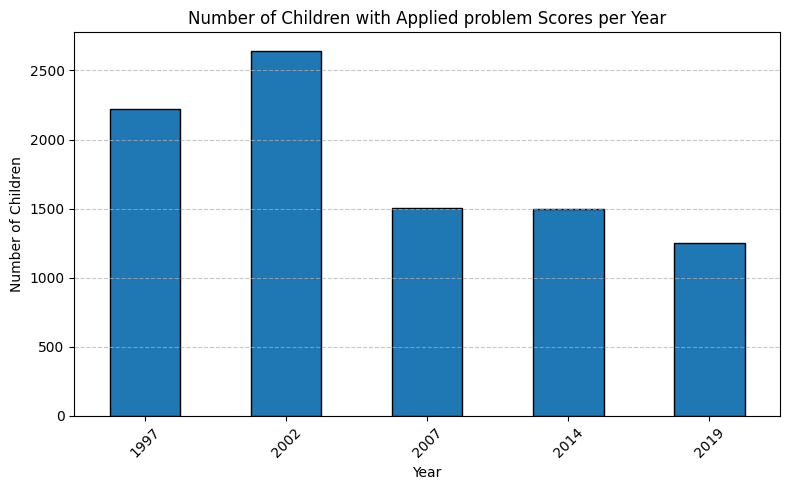

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

year_counts = cds_all["year"].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
year_counts.sort_index().plot(kind='bar', edgecolor='black')
plt.title("Number of Children with Applied problem Scores per Year")
plt.xlabel("Year")
plt.ylabel("Number of Children")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**The number of children with Applied Problem scores peaked in 2002 and declined in subsequent CDS waves. This trend likely reflects the original 1997 CDS cohort aging out over time, with fewer newly eligible children added in later waves.**

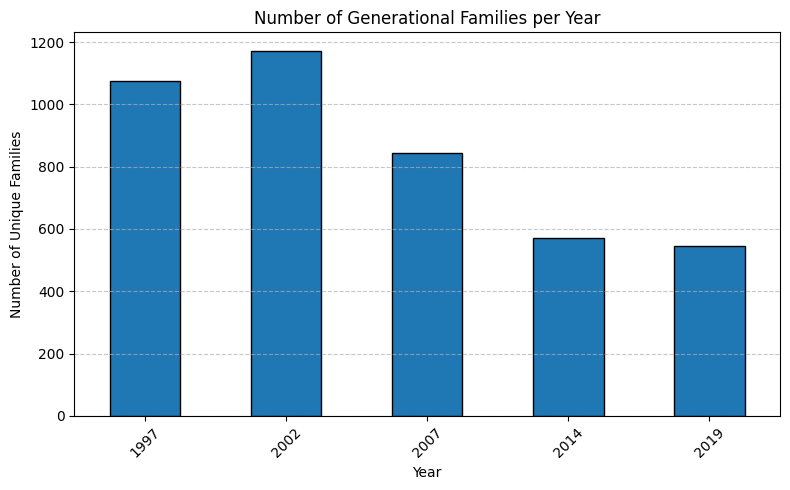

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Count unique families per year (assuming 'ER30001' is the family ID)
family_counts = cds_all.groupby("year")["ER30001"].nunique()

# Plot
plt.figure(figsize=(8, 5))
family_counts.sort_index().plot(kind='bar', edgecolor='black')
plt.title("Number of Generational Families per Year")
plt.xlabel("Year")
plt.ylabel("Number of Unique Families For the CDS")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**The number of generational families represented in each CDS wave declines after 2002, which is expected as the sample ages and fewer new child participants are recruited. This highlights the importance of cohort design in interpreting trends over time**

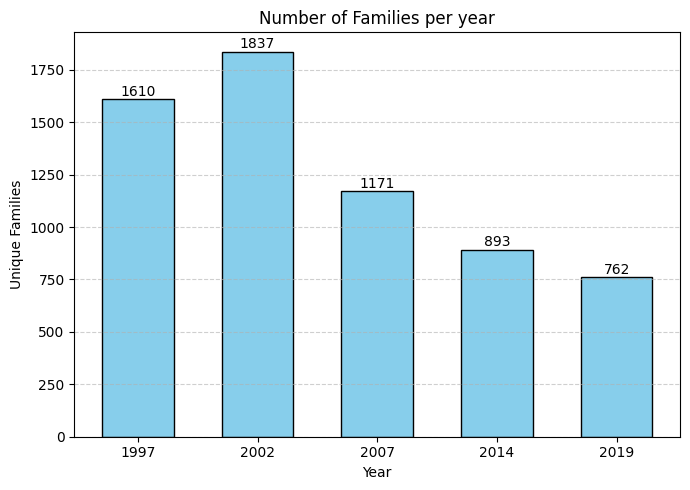

In [ ]:
import matplotlib.pyplot as plt

# Number of families per CDS wave — using unique family ID counts
families_by_year = {
    1997: child97['ER33401'].nunique(),
    2002: child02['ER33601'].nunique(),
    2007: child07['ER33901'].nunique(),
    2014: child14['ER34201'].nunique(),
    2019: child19['ER34701'].nunique()
}



# Use index positions for tighter bars
x = list(range(len(families_by_year)))
heights = list(families_by_year.values())
labels = list(families_by_year.keys())

# Plot
plt.figure(figsize=(7, 5))
bars = plt.bar(x, heights, edgecolor="black", color="skyblue", width=0.6)

# Add labels
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(heights[i]), ha='center', va='bottom', fontsize=10)

# Custom x-axis
plt.xticks(x, labels)
plt.title("Number of Families per year for the CDS")
plt.xlabel("Year")
plt.ylabel("Unique Families")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



**The number of families participating in each CDS wave peaked in 2002 and steadily declined in later years. This pattern reflects the original cohort aging out and limited recruitment of new families in subsequent waves.**

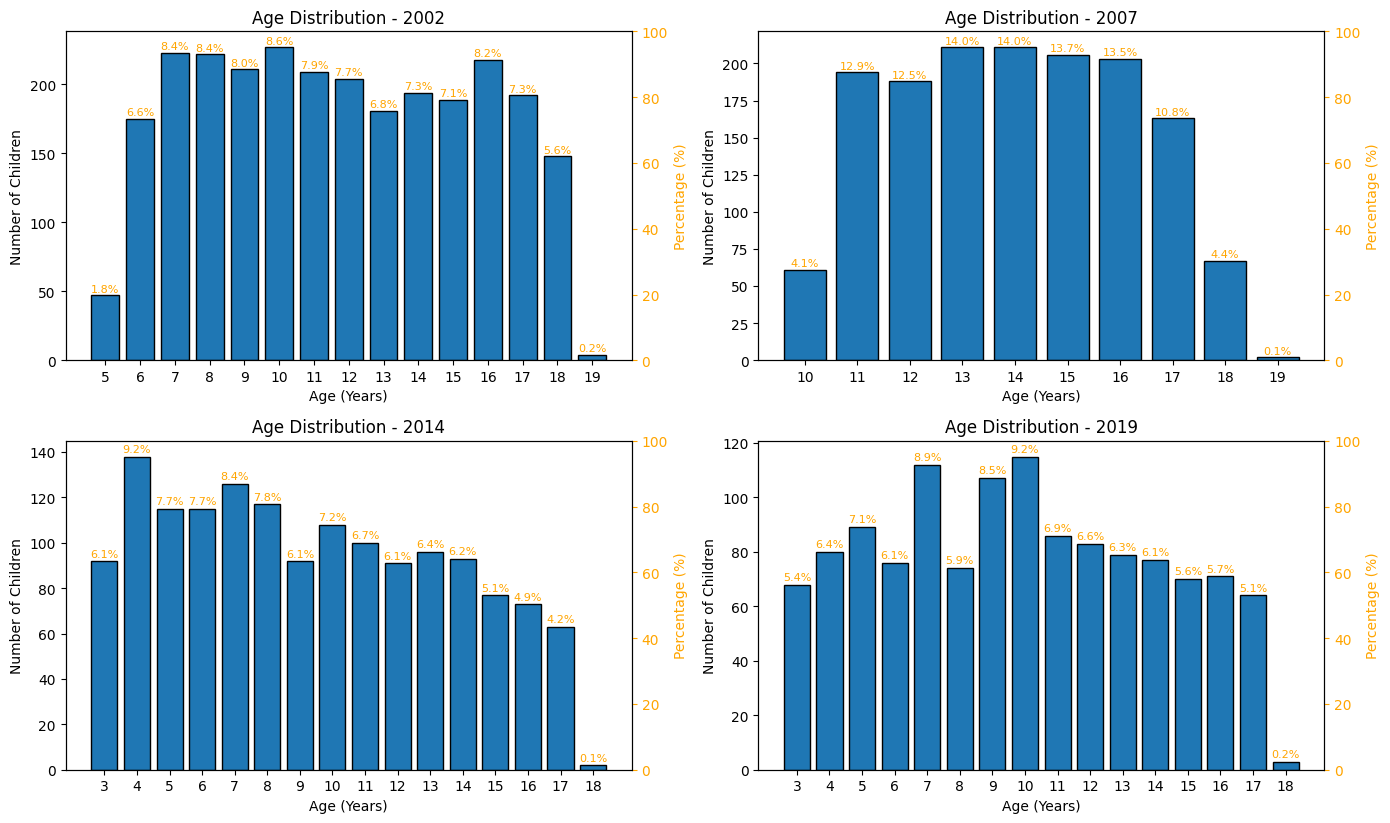

In [ ]:


age_columns = {
    2002: "Q24IWAGE",
    2007: "Q34IWAGE",
    2014: "A14IWAGE",
    2019: "A19IWAGE"
}
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axes = axes.flatten()

for idx, (year, age_col) in enumerate(age_columns.items()):
    if age_col in cds_all.columns:
        # Convert age from months to integer years
        age_data = pd.to_numeric(cds_all[cds_all["year"] == year][age_col], errors='coerce').dropna()
        age_years = (age_data // 12).astype(int)

        # Count per age
        age_counts = age_years.value_counts().sort_index()
        ages = age_counts.index
        counts = age_counts.values
        total = counts.sum()
        percents = counts / total * 100

        # Left Y-axis: count
        ax1 = axes[idx]
        bars = ax1.bar(ages, counts, edgecolor='black')
        ax1.set_xlabel("Age (Years)")
        ax1.set_ylabel("Number of Children")
        ax1.set_title(f"Age Distribution - {year} for the CDS")
        ax1.set_xticks(ages)

        # Right Y-axis: percent
        ax2 = ax1.twinx()
        ax2.set_ylabel("Percentage (%)", color='orange')
        ax2.set_ylim(0, 100)
        ax2.tick_params(axis='y', colors='orange')

        # Optionally overlay percent as text
        for bar, pct in zip(bars, percents):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2, height + 1, f"{pct:.1f}%",
                     ha='center', va='bottom', fontsize=8, color='orange')

# Remove unused subplot if present
for i in range(len(age_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



**The age distributions across CDS waves reflect the aging of the original 1997 cohort and changes in recruitment. In 2002 and 2007, older children (ages 7–17) dominate the sample, while the 2014 and 2019 waves include more younger children again, indicating a partial refresh of the cohort or inclusion of new children in PSID families.**

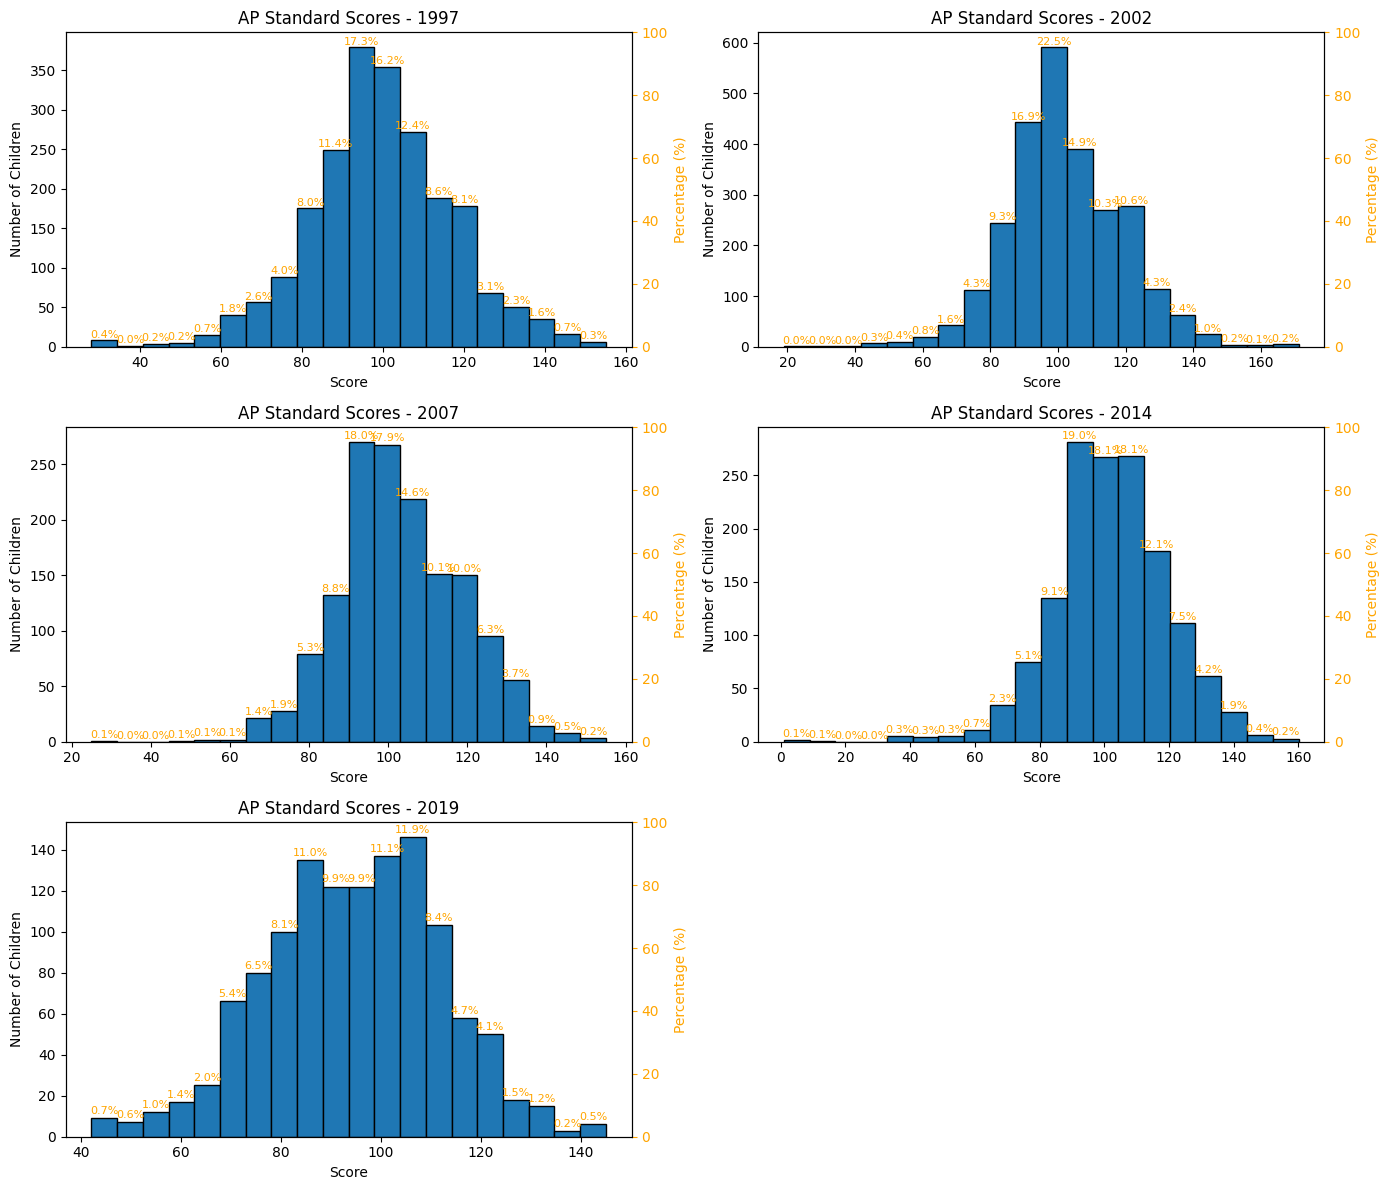

In [ ]:
score_columns = {
    1997: "Q3AP_SS",
    2002: "Q24APSS",
    2007: "Q34APSS",
    2014: "A14APSS",
    2019: "A19APSS"
}



fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axes = axes.flatten()

for idx, (year, score_col) in enumerate(score_columns.items()):
    if score_col in cds_all.columns:
        # Get scores
        scores = pd.to_numeric(cds_all[cds_all["year"] == year][score_col], errors='coerce').dropna()
        scores= scores[(scores !=999) &(scores !=996) &(scores !=995) &(scores !=0)]

        # Create bins and histogram manually
        counts, bins = pd.cut(scores, bins=20, retbins=True, right=False)
        bin_counts = counts.value_counts().sort_index()
        bin_labels = [f"{int(interval.left)}–{int(interval.right)}" for interval in bin_counts.index]
        bin_centers = [(interval.left + interval.right) / 2 for interval in bin_counts.index]
        total = bin_counts.sum()
        percentages = (bin_counts / total * 100)

        # Plot count bars
        ax = axes[idx]
        bars = ax.bar(bin_centers, bin_counts.values, width=(bins[1] - bins[0]), align='center', edgecolor='black')
        ax.set_title(f"Applied Problems Standard Scores - {year} For The CDS ")
        ax.set_xlabel("Score")
        ax.set_ylabel("Number of Children")

        # Right Y-axis: percentage
        ax2 = ax.twinx()
        ax2.set_ylabel("Percentage (%)", color='orange')
        ax2.set_ylim(0, 100)
        ax2.tick_params(axis='y', colors='orange')

        # Optional: add % labels
        for bar, pct in zip(bars, percentages):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{pct:.1f}%",
                    ha='center', va='bottom', fontsize=8, color='orange')

# Hide unused subplot
for i in range(len(score_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



**These histograms show the distribution of standard scores on the Applied Problem (AP) test across CDS waves from 1997 to 2019. Each wave follows a roughly normal distribution centered around a mean of 100, which is expected given standardized scoring. Over time, the distributions remain consistent, indicating stable test performance across cohorts despite variation in sample size. The slight spread differences reflect natural sampling variation and changes in test-taking groups over the years.**

===============================================================================


In our opinion, the data quality overall supports our research rather than undermining it. The consistently low nonresponse rates across waves and family structures give us confidence that missing data isn’t a major concern. The stability in the distribution of applied problem scores over time also reinforces the reliability of this measure, which is central to our analysis. While the sample size does decline in later waves, that drop is expected due to aging cohorts, and it doesn’t appear to distort the trends we’re interested in. So overall, we believe the structure and consistency of the data work in favor of our research goals.

#CDS And Indiv Data and supplemt(2016 with 2014 CDS)

##Initialize

In [ ]:
import pandas as pd
cds_allNo=pd.read_parquet('/content/extracted_data/MergedData/cds_all_Nofilter.parquet')
merged = pd.read_parquet("/content/extracted_data/MergedData/IndALL_2015_2016.parquet")


In [ ]:
child=set(cds_allNo[cds_allNo['year']==2014]['ER34201'])
parents= pd.merge(merged[merged['year']==2013], merged[merged['year']==2016], on=['Perm_FID','Perm_IID'], how='inner',    suffixes=('_2013', '_2016')
)
parents.rename(columns={'ER34201_2016': 'ER342011', 'ER34202_2016': 'ER342022','ER34201_2013': 'ER34201', 'ER34202_2013': 'ER34202'},inplace=True)
filtered_parents = parents[parents['ER34201'].isin(child)].copy()
fmily= set(parents['ER34201'])

In [ ]:
cds_allNo.rename(columns={'ER30001': 'Perm_FID', 'ER30002': 'Perm_IID'},inplace=True)
children= pd.merge(cds_allNo[cds_allNo['year']==2014], merged[merged['year']==2013], on=['ER34201','ER34202'], how='right')

In [ ]:
filtered_children = cds_allNo[cds_allNo['ER34201'].isin(fmily)].copy()

In [ ]:
filtered_children_parents = pd.concat([filtered_children, filtered_parents], ignore_index=True)

In [ ]:
filtered_children_parents
childrenAnswered=filtered_children_parents[filtered_children_parents['A14APW'].notnull()]
parentsAnswered=filtered_children_parents[filtered_children_parents['WB16K1_2016'].notnull()]
parentsAnswered = parents[parents['ER34201'].isin(set(childrenAnswered['ER34201']))].copy()


##Analysis

In [ ]:
print("Number of parents who participated in the 2016 survey, answered the question, and have children who were tested: ", len(parentsAnswered))

print("Number of children who participated in the 2014 survey, answered the question, and have parents who were surveyed in 2016: ", len(childrenAnswered))


Number of parents who participated in the 2016 survey, answered the question, and have children who were tested:  820
Number of children who participated in the 2014 survey, answered the question, and have parents who were surveyed in 2016:  959


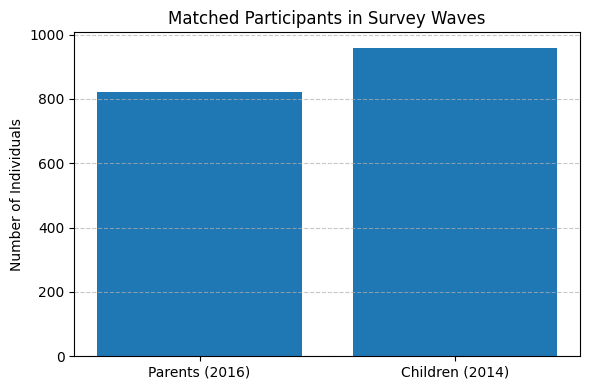

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
labels = ['Parents (2016)', 'Children (2014)']
counts = [len(parentsAnswered), len(childrenAnswered)]

# Create bar plot
plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.title("Matched Participants in Survey Waves")
plt.ylabel("Number of Individuals")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:

# Compute correlation
correlation = childrenAnswered['A14APW'].corr(parentsAnswered['WB16K1_2016'])

print("Correlation between child and parent scores:", correlation)


Correlation between child and parent scores: -0.045772432921065476


**As shown above, the correlation between the two tests is near
zero. This may be due to the difference in the nature of the assessments: the children's test had a maximum score of 160, while the parent's test was a single-question item with a binary outcome (correct or incorrect).**
